# Mahindra First Choice `Data Analysis`

### Problem Statements
    1. Geolocation Based Customer Analysis
        * Explore how various factors like make, model, time & type of service, etc vary with location.
            * Identifying the ownership pattern of cars throughout the country.
            * This also captures the problem wherein information regarding the spending patterns can be identified.
        * Identify the type of order each state receives and present it as an interactive visualization.
    2. Market Segmentation
        * Divide market of potential customers into internally homogeneous and mutually heterogeneous groups or segments.
            * To be based on different characteristics captured in the data.
     3. Customer Lifetime value prediction

#### Further Problem Statements
    1. Inventory Management and Recommendation
    2. Marketing Recommendation
    3. Customer Prediction

### The Data

* Dataset contains the following:
    1. Customer Data
    2. Invoice Data
    3. Joint Technical Data
    4. Plant Master
    
* Data from 1st April 2012 to 31st October 2016
    * 1675 days
    * 55 months
    * 40200 hours

---

## 1. Data Cleaning and Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import sys
import time
import warnings

from matplotlib import pyplot as plt
from scipy import stats
from my_utils import *

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [2]:
customer_data = pd.read_excel("redacted/data/Customer_Data.xlsx", sheet_name='Sheet1')

In [3]:
invoice = pd.read_csv("redacted/data/Final_invoice.csv", index_col=0)

In [4]:
jtd = pd.read_csv("redacted/data/JTD.csv", index_col=0)

In [5]:
plant_master = pd.read_excel("redacted/data/Plant Master.xlsx", sheet_name='Sheet1')

---

### 1.1 Customer Data

In [6]:
check_null(customer_data)

Total Columns: 555338


,Number_Missing,% Missing,Missing?
Death date,554675,99.880613,True
Date of Birth,541894,97.579132,True
Occupation,540780,97.378533,True
Marital Status,539301,97.112209,True
Title,46307,8.338525,True
Data Origin,136,0.024490,True
Partner Type,78,0.014046,True


* `Death date`, `Date of Birth`, `Occupation` and `Marital Status` have a high number of missing values which would not be possible to impute. Hence dropping these columns.
* `Partner Type` and `Data Origin` have too few a number of missing values which may not justify the time and effort to be put in for diminished gains. Hence dropping the entries where these columns have missing values.

In [7]:
if 'Occupation' in customer_data.columns:
    customer_data.drop(columns=['Death date', 'Date of Birth', 'Occupation', 'Marital Status'], axis=1, inplace=True)
if 'Partner Type' in customer_data.columns:
    customer_data.drop(customer_data[customer_data['Partner Type'].isnull() | customer_data['Data Origin'].isnull()].index,
                       axis=0, inplace=True)

In [8]:
check_null(customer_data)

Total Columns: 555202


,Number_Missing,% Missing,Missing?
Title,46177,8.317153,True


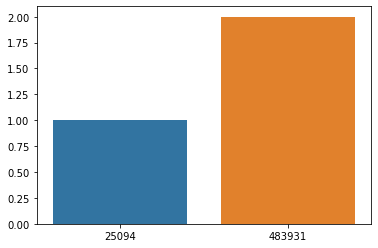

In [9]:
_ = customer_data['Title'].value_counts()
__ = sns.barplot(x=_.values, y=_.index)

* `Title` only contains `Mr.` and `Mrs.`. `Company` and `Mr. and Mrs` weren't found.
* Randomly imputing the missing `Title` values based on their distribution.

In [10]:
titles = ['Mr.', 'Mrs.']
customer_data['Title'] = np.where(customer_data['Title'].isnull(),
                         titles[math.floor(random.random()*((483931 + 25094)/483931))], 
                         customer_data['Title'])

* All values in `customer_data` have been imputed.

In [11]:
check_recurring(customer_data)

,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
4,Title,3,555202,0.000005,False
2,Partner Type,7,555202,0.000013,False
3,Data Origin,22,555202,0.000040,False
0,Business Partner,555202,555202,1.000000,False
1,Customer No.,555202,555202,1.000000,False


* `Customer No.` and `Business Partner` seem to be some sort of identifiers for internal and external systems.
* Both contain only unique values.
* They do not offer any prediction power but may aid in merging, hence, are being kept.
* Performing One-Hot encoding on Categorical data types.

In [12]:
customer_data = pd.get_dummies(customer_data, columns=['Partner Type', 'Data Origin', 'Title'])
customer_data.head()

,Business Partner,Customer No.,Partner Type_1.0,Partner Type_2.0,Partner Type_3.0,Partner Type_4.0,Partner Type_9001.0,Partner Type_9002.0,Partner Type_9003.0,Data Origin_Z001,...,Data Origin_Z016,Data Origin_Z017,Data Origin_Z018,Data Origin_Z019,Data Origin_Z020,Data Origin_Z021,Data Origin_Z022,Title_1.0,Title_2.0,Title_Mr.
0,31,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,32,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,34,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,35,5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,42,7,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
customer_data.to_csv("redacted/processed data/customer_data_check1.csv", index=False)

---

### 1.2 Invoice

In [14]:
missing_df = check_null(invoice)
missing_df

Total Columns: 492314


,Number_Missing,% Missing,Missing?
Service Advisor Name,492314,100.000000,True
Claim No.,487510,99.024200,True
Policy no.,475432,96.570888,True
Expiry Date,470083,95.484386,True
Insurance Company,468723,95.208140,True
Cash /Cashless Type,464894,94.430384,True
Gate Pass Date,451399,91.689247,True
Technician Name,236834,48.106290,True
Total IGST,197286,40.073205,True
Total GST,197286,40.073205,True


In [15]:
recurring_df = check_recurring(invoice)
recurring_df

,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
0,Amt Rcvd From Custom,1,295028,0.000003,True
1,Amt Rcvd From Ins Co,1,295028,0.000003,True
3,CGST(14%),1,295028,0.000003,True
4,CGST(2.5%),1,295028,0.000003,True
5,CGST(6%),1,295028,0.000003,True
6,CGST(9%),1,295028,0.000003,True
16,IGST(12%),1,295028,0.000003,True
17,IGST(18%),1,295028,0.000003,True
18,IGST(28%),1,295028,0.000003,True
19,IGST(5%),1,295028,0.000003,True


* Dropping columns with more than 90% missing values and those with a single value.

In [16]:
columns_to_drop = set()

# more than 90% missing values
for i in list(missing_df[missing_df['% Missing']>90].index):
    columns_to_drop.add(i)

# columns that have just a single value
for i in list(recurring_df[ recurring_df['Unique Values']==1]['Column']):
    columns_to_drop.add(i)

# dropping the columns
invoice.drop(columns=list(columns_to_drop), axis=1, inplace=True)

* Dropping columns with too few missing values.

In [17]:
# dropping records where missing values are low
# not dropping `Model` as it may provide predictive power in areas with less data
invoice.drop(invoice[ invoice['Regn No'].isnull() | invoice['CITY'].isnull()].index,
             axis=0, inplace=True)

In [18]:
check_null(invoice)

Total Columns: 492297


,Number_Missing,% Missing,Missing?
Technician Name,236822,48.105514,True
ODN No.,197282,40.073777,True
Total Value,197282,40.073777,True
Area / Locality,23889,4.852559,True
Model,1524,0.309569,True


* Now the remaining fields <code>['Technician Name', 'Total Value', 'ODN No.']</code> remain with significant missing values.
* <code>Technician Name</code> may later prove useful for Customer Prediction.
* <code>ODN No.</code> contains unique values apart from those missing. It doesn't give much else information and doesn't seem to be of use for any other tasks. Will drop it.
* <code>Total Value</code> contains the values same as <code>Total Amt Wtd Tax.</code>, hence will be dropping it as well.

In [19]:
invoice.drop(columns=['Total Value', 'ODN No.'], axis=1, inplace=True)
invoice['Technician Name'].fillna(value='Missing', inplace=True)

In [20]:
check_null(invoice)

Total Columns: 492297


,Number_Missing,% Missing,Missing?
Area / Locality,23889,4.852559,True
Model,1524,0.309569,True


* Sincecustomer segmentation needs to be carried out on their geological location, the 4.8% missing values in `['Area / Locality']` needs to be imputed.
* This will be done using the <code>District</code> column and <code>Plant Master</code> data.

In [21]:
def clean_and_add_values(plant_property):
    '''
    Imputes missing values based on most sensible mode.
    '''
    property_index = []
    property_value_counts = plant_property.value_counts()
    if type(property_value_counts.index[0]) == str:
        property_index = [ x.lower() for x in list(property_value_counts.index)] 
    else:
        property_index = list(property_value_counts.index)
        
    property_values = list(property_value_counts.values)
    
    property_index_set = set(property_index)
    
    # if there's more than one value
    if len(property_index_set) > 1:
        # find the occurences of all the different values' case occurrences
        for i in property_index_set:
            property_index_occurences = [k for k, x in enumerate(property_index) if x == i]
            if len(property_index_occurences) > 1:
                # add multiple occurences of different case values
                for j in range(1, len(property_index_occurences)):
                    property_values[property_index_occurences[0]] += property_values[j]
                    property_values[j] = 0
                    
    property_cleaned_and_added = pd.Series(data=property_values, index=property_value_counts.index)
    property_cleaned_and_added = property_cleaned_and_added.sort_values(ascending=False)
    
    property_decided_value = \
        property_cleaned_and_added[property_cleaned_and_added == property_cleaned_and_added.iloc[0]].index[0]
    
    chosen_index = 1
    if type(property_decided_value) == str:
        if len(property_decided_value.strip()) < 2:
            while( property_decided_value in [',', '.', '..', '...']):
                property_decided_value = \
                    property_cleaned_and_added[property_cleaned_and_added == property_cleaned_and_added.iloc[chosen_index]].index[0]
                chosen_index += 1
    return property_decided_value

In [22]:
plants = sorted(list( set(invoice['Plant'])))

In [23]:
final_invoice = invoice.copy()

for i in range(0, len(plants)):
    
    j = plants[i]
    properties_to_clean = ['CITY', 'Area / Locality', 'District', 'Pin code', 'Plant Name1']
    
    for property_ in properties_to_clean:
        cleaned_property = clean_and_add_values(final_invoice[ final_invoice['Plant'] == j ][property_])
        final_invoice[property_] = np.where(final_invoice['Plant'] == j, 
                                            cleaned_property, 
                                            final_invoice[property_])
        
    print(' '*40, end="")
    print("\r{0}% completed      ".format(np.around( i/len(plants)*100, decimals=2)), end="")
print("\r100% Complete      ")

84.71% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

100% Complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [24]:
invoice = final_invoice.copy()

* Imputing car `Model` using `Regn No`.

In [25]:
# imputing car models using number plate data

for number_plate in list(invoice[ invoice['Model'].isnull() ]['Regn No']):
    car_records = invoice[ invoice['Regn No'] == number_plate][['Customer No.', 'Make', 'Model']]
    
    if len(car_records[ car_records['Model'].notnull() ]) >= 1:
        
        car_model_value_counts = car_records['Model'].value_counts().sort_values(ascending=False)
        
        invoice['Model'] = np.where(invoice['Regn No'] == number_plate,
                                    car_model_value_counts.index[0], 
                                    invoice['Model'])

* Further imputation would require manual input or random values. This may introduce noise in the data.
* Dropping the remaining values.

In [26]:
invoice.drop(invoice[ invoice['Model'].isnull() ].index, axis=0, inplace=True)

* All values in `invoice` have been imputed.
<br><br>
* First, let's take a look at data quality.
* Plotting `KMs Reading`.

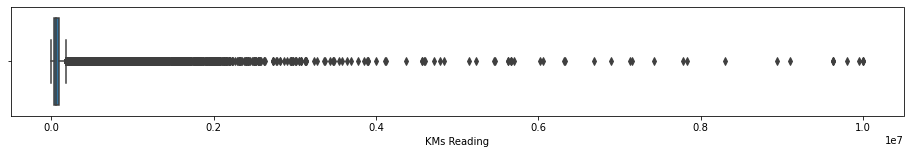

In [27]:
fig, ax = plt.subplots(figsize=(16, 2))
__ = sns.boxplot(x=invoice['KMs Reading'])

* `KMs Reading` has a high number of outliers.
* Note that some values are as high as 10,000,000 km, which is incorrect as on an average, cars experience very significant wear and tear by the time they've been driven about 200,000 to 300,000 km.
<br><br>
* Plotting the distribution of data based on `KMs Reading` less than and greater than `300,000` km.

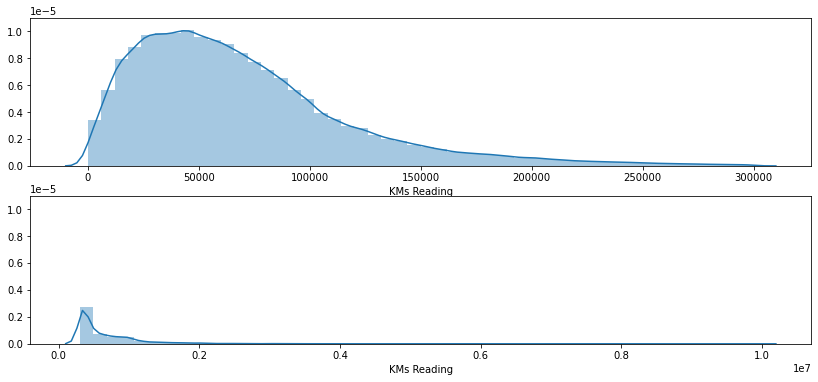

In [28]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 6))
__ = ax[0].set_ylim(0, 1.1*1e-5)
__ = ax[1].set_ylim(0, 1.1*1e-5)

__ = sns.distplot(invoice[invoice['KMs Reading'] <= 300000]['KMs Reading'], ax=ax[0])
__ = sns.distplot(invoice[invoice['KMs Reading'] > 300000]['KMs Reading'], ax=ax[1])

* The data is now much more usable and believable.
<br><br>
* Dropping records with greather than `300,000` km as `KMs Reading`.

In [29]:
mask = invoice['KMs Reading'] > 300000
invoice.drop(invoice[ mask ].index, axis=0, inplace=True)

* Checking `Total Amt Wtd Tax.` values.

In [30]:
invoice[invoice['Total Amt Wtd Tax.'] < 0][['Total Amt Wtd Tax.']]

,Total Amt Wtd Tax.
752945,-0.01
766351,-0.01
812907,-0.01
812910,-0.01
813825,-0.01
849144,-0.01
855211,-137.00
880895,-0.01


* Dropping negative `Total Amt Wtd Tax.` values.

In [31]:
invoice.drop(invoice[invoice['Total Amt Wtd Tax.'] < 0].index, axis=0, inplace=True)

* Across the invoice data, the same <code>Regn No</code> comes up more than once, indicating that some `frequent customers` exist.
* The number of times a car has visited the shop may aid in segmentation.
* Creating new features `Regn No_frequency` and `Customer No._frequency`.

In [32]:
def attach_frequency(df, column):
    '''Takes a dataframe and column name as input. Returns the dataframe
    with an additional column which contains the freqeuncy of the values
    in the column'''
    frequency = df[column].value_counts().to_frame().reset_index()
    frequency.columns = [column, f'{column}_frequency']
    return pd.merge(left=df, right=frequency, on=column, how='left')

In [33]:
# attaching freguency of car Regn No and Customer No

invoice = attach_frequency(invoice, 'Regn No')
invoice = attach_frequency(invoice, 'Customer No.')

In [34]:
invoice.head()

,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,Job Card No,...,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency
0,THANE,THANE,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,168303,...,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5
1,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,173997,...,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6
2,THANE,THANE,Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,173889,...,BC01,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3
3,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,174158,...,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6
4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,173860,...,BC01,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8


* First thing to notice is that in some places `Regn No_frequency` is not equal to `Customer No._frequency`.
* This may mean that either a customer has more than one vehicle or a vehicle was owned by a previous customer.

In [35]:
# checking to see if there is any imbalanced in customer no and regn no frequency
# imbalance would mean a car was owned by different 

invoice[ invoice['Regn No_frequency'] > invoice['Customer No._frequency']]

,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,Job Card No,...,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency
261,THANE,THANE,Retail,E25519,Maharashtra,00:00:00,2015-01-30,7005200263,17:02:06,182027,...,BC01,THANE,NO,0.0,MH04DN6210,SAMEER,1205.09,BC01SA1,52,11
292,PUNE,PUNE,Retail,68935,Maharashtra,00:00:00,2015-01-02,7006200007,17:23:54,173892,...,BC02,PUNE,NO,0.0,MH12HY3999,umakant,299.92,BC02SA2,6,4
339,PUNE,PUNE,Retail,85418,Maharashtra,00:00:00,2015-01-09,7006200055,11:03:19,175994,...,BC02,PUNE,NO,0.0,MH14CS4118,KIRAN,1002.18,BC02WM1,7,6
342,PUNE,PUNE,Retail,85418,Maharashtra,00:00:00,2015-01-09,7006200058,11:56:30,176025,...,BC02,PUNE,NO,0.0,MH14CS4118,UMAKANT,0.00,BC02SA2,7,6
345,PUNE,PUNE,Retail,85418,Maharashtra,00:00:00,2015-01-09,7006200061,15:04:09,176029,...,BC02,PUNE,NO,0.0,MH14CS4118,UMAKANT,419.74,BC02SA2,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484288,RAMNAGAR,RAMNAGAR,Retail,202219,Uttarakhand,00:00:00,2016-06-28,7198600001,18:36:14,397389,...,X243,X243 - JINDAL AUTOMOBILES,NO,0.0,UK04L4033,Missing,5702.70,X243SA1,3,2
484353,NAMAKKAL,NAMAKKAL,Retail,198247,Tamil Nadu,00:00:00,2016-06-27,7199800098,19:23:38,398070,...,X249,X249 - AMBUJA'S AUTOMOTIVES,NO,0.0,TN02AF9596,Missing,99.14,X249SA1,4,3
484364,NAMAKKAL,NAMAKKAL,Retail,201671,Tamil Nadu,00:00:00,2016-06-28,7199800112,19:25:45,396463,...,X249,X249 - AMBUJA'S AUTOMOTIVES,NO,0.0,TN28AC1810,Missing,99.14,X249SA1,2,1
484509,SURAT,SURAT,Retail,195577,Gujarat,00:00:00,2016-06-30,7205801297,14:51:03,400712,...,X279,X279 - J B CAR CARE,NO,0.0,GJ5JK0011,Missing,599.14,X279WM1,3,2


* There exist cars that have been owned by 2 or more known customers.
<br><br>
* Creating a new boolean feature `Pre-owned_by_Known`.

In [36]:
invoice['Pre-owned_by_Known'] = (invoice['Regn No_frequency'] > invoice['Customer No._frequency']).astype(int)

In [37]:
invoice.head()

,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,Job Card No,...,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Pre-owned_by_Known
0,THANE,THANE,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,168303,...,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,5,5,0
1,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,173997,...,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,6,6,0
2,THANE,THANE,Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,173889,...,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,3,3,0
3,THANE,THANE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,174158,...,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,6,6,0
4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,173860,...,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,8,8,0


* Creating new features to keep track of events such as customer/car visits.

In [38]:
def occurrences_a_wrt_b(a, b, df, name):
    '''
    Finds occurrences of "A" with respect to occurences of "B".
    Appends counts of occurrences and a string separated by
    commas and returns the resultant DataFrame.
    !Pass DataFrame with a standard index!
    '''
    b_to_a = {}
    
    # using a dictionary to store occurreces of b using sets
    # using value of b as key
    for indice in df.index:
        try:
            b_to_a[df.at[indice, b]].add(df.at[indice, a])
        except:
            b_to_a[df.at[indice, b]] = set([invoice.at[indice, a]])
    
    # storing counts of occurrences using b_to_a
    b_to_a_counts = {}
    
    for key in b_to_a.keys():
        b_to_a_counts[key] = len(b_to_a[key])
    
    # converting the different occurences of `a` to string separated with comma
    for key in b_to_a.keys():
        if len(b_to_a[key]) == 1:
            b_to_a[key] = list(b_to_a[key])[0]
        else:
            b_to_a[key] = ', '.join([j for j in b_to_a[key]])
        
    df.set_index(b, inplace=True)
    
    df[name] = pd.Series(b_to_a)
    df[f'{name} Count'] = pd.Series(b_to_a_counts)
    df.reset_index(inplace=True)
    
    return df

* Creating a new features 
    * `Plants visited by Customer`
    * `Plants visited by Customer Count`
    * `Plants visited by Car`
    * `Plants visited by Car Count`

In [39]:
invoice = occurrences_a_wrt_b(a='Plant', b='Customer No.', df=invoice, name='Plants visited by Customer')
invoice = occurrences_a_wrt_b(a='Plant', b='Regn No', df=invoice, name='Plants visited by Car')

In [40]:
invoice.head()

,Regn No,Customer No.,Area / Locality,CITY,Cust Type,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Technician Name,Total Amt Wtd Tax.,User ID,Regn No_frequency,Customer No._frequency,Pre-owned_by_Known,Plants visited by Customer,Plants visited by Customer Count,Plants visited by Car,Plants visited by Car Count
0,KA19MA1291,67849,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,...,RUPESH,4051.95,BC01FS1,5,5,0,BC01,1,BC01,1
1,MH43R3046,84419,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,...,PRASHANT,1001.29,BC01SA2,6,6,0,BC01,1,BC01,1
2,AP09AX0582,81055,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,...,IMRAN,233.14,BC01SA2,3,3,0,BC01,1,BC01,1
3,MH43R3046,84419,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,...,PRASHANT,0.00,BC01SA2,6,6,0,BC01,1,BC01,1
4,MH04CD9768,18980,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,...,DAYANAND,2747.12,BC01SA2,8,8,0,BC01,1,BC01,1


* Let's check if there's any relation between `Plants visited by Car` and `KMs Reading`.

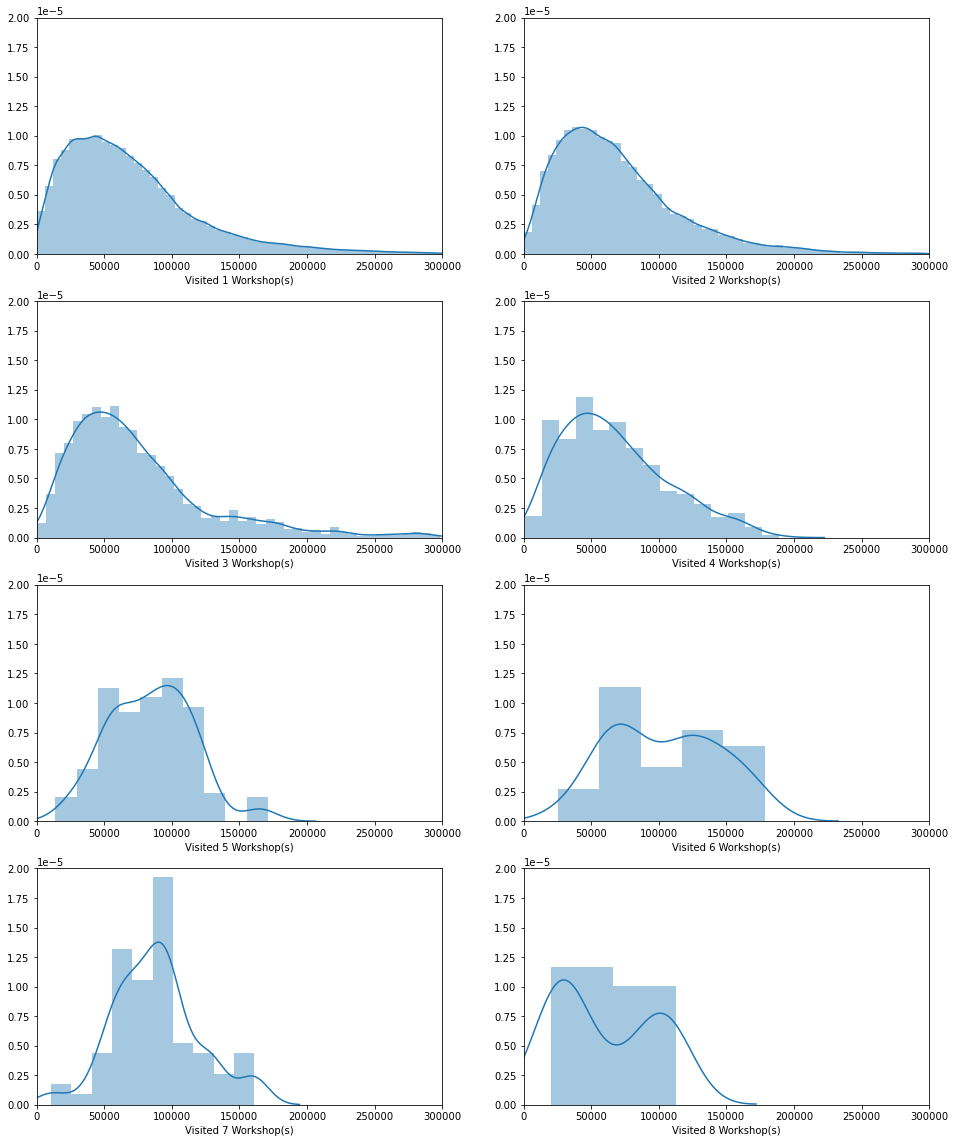

In [41]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

for count in invoice['Plants visited by Car Count'].unique():
    mask = (invoice['Plants visited by Car Count'] == count)
    
    row = (count-1)//2
    col = (count-1)%2

    _ = ax[row][col].set_xlim(0, 300000)
    _ = ax[row][col].set_ylim(0, 2*1e-5)
    
    _ = sns.distplot(invoice[ mask ]['KMs Reading'], 
                     ax=ax[row][col], 
                     axlabel=f'Visited {count} Workshop(s)')

* A new trend is observed where `Plants visited by Car` > 4 where a new distribution peak is observed around `100,000`km.
* These may be commercial vehicles (taxis, pickup trucks, etc) or customers who like to travel.
<br><br>
* Creating new features
    * `Vehicle Owner`
    * `Vehicle Owner Count`
    * `Cars Owned`
    * `Cars Owned Count`

In [42]:
invoice = occurrences_a_wrt_b(a='Customer No.', b='Regn No', df=invoice, name='Vehicle Owner')
invoice = occurrences_a_wrt_b(a='Regn No', b='Customer No.', df=invoice, name='Cars Owned')

In [43]:
invoice.head()

,Customer No.,Regn No,Area / Locality,CITY,Cust Type,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,...,Customer No._frequency,Pre-owned_by_Known,Plants visited by Customer,Plants visited by Customer Count,Plants visited by Car,Plants visited by Car Count,Vehicle Owner,Vehicle Owner Count,Cars Owned,Cars Owned Count
0,67849,KA19MA1291,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,...,5,0,BC01,1,BC01,1,67849,1,KA19MA1291,1
1,84419,MH43R3046,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,...,6,0,BC01,1,BC01,1,84419,1,MH43R3046,1
2,81055,AP09AX0582,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,...,3,0,BC01,1,BC01,1,81055,1,AP09AX0582,1
3,84419,MH43R3046,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,...,6,0,BC01,1,BC01,1,84419,1,MH43R3046,1
4,18980,MH04CD9768,THANE,THANE,Retail,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,...,8,0,BC01,1,BC01,1,18980,1,MH04CD9768,1


* Let's see how the `mean revenue` varies with `multiple-car owners` and `single-car owners`

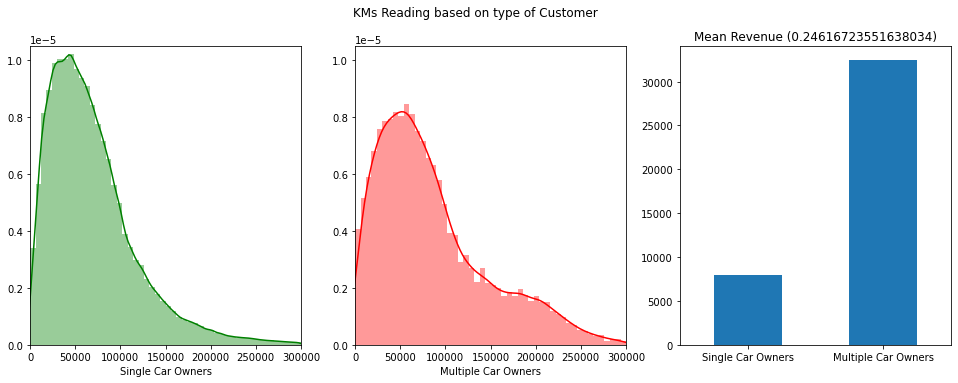

In [44]:
height = 5.5
width = 3*height
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(width, height))
_ = fig.suptitle('KMs Reading based on type of Customer')

_ = ax[0].set_xlim(0, 300000)
_ = ax[0].set_ylim(0, 1.05*1e-5)
_ = ax[1].set_xlim(0, 300000)
_ = ax[1].set_ylim(0, 1.05*1e-5)

mask = (invoice['Cars Owned Count'] == 1)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
             axlabel='Single Car Owners', 
             color='Green', 
             ax=ax[0])

mask = (invoice['Cars Owned Count'] > 1)
_ = sns.distplot(invoice[mask]['KMs Reading'], 
             axlabel='Multiple Car Owners', 
             color='Red',
             ax=ax[1])
# plt.show()

_ = []

mask = invoice['Cars Owned Count'] == 1
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

mask = invoice['Cars Owned Count'] > 1
_.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())

_ = pd.Series(_, index=['Single Car Owners', 'Multiple Car Owners']) \
        .plot(kind='bar', ax=ax[2], title=f'Mean Revenue ({_[0]/_[1]})')
_ = plt.xticks(rotation=0)

In [51]:
len(invoice[(invoice['Cars Owned Count'] > 1)])
len(invoice[(invoice['Cars Owned Count'] == 1)])

35678 / (35678 + 449012)

35678

449012

0.07360993624791104

* It's observed that customers with multiple cars keep them for longer.
* `Multiple-car owners` offer `4 times` the business based on mean revenue.
<br><br>
* Let's look at how customer behavior is affected if a car is first hand or second hand.
* While at it, the last service by the first customer will also be noted in order to estimate when customers sell their cars.

In [52]:
invoice['First_Hand_Owner'] = 0

In [53]:
start_time = time.time()
mask_1 = invoice['Vehicle Owner Count'] > 1

for i, car in enumerate(invoice[mask_1]['Regn No'].unique()):
    mask_2 = invoice['Regn No'] == car
    req_km = invoice[mask_2]['KMs Reading'].min()
    req_customer = invoice[mask_2 & (invoice['KMs Reading']==req_km)]['Customer No.'].unique()[0]
    
    invoice['First_Hand_Owner'] = np.where((invoice['Regn No'] == car) \
                                               & (invoice['Customer No.'] == req_customer), 
                                           1,
                                           invoice['First_Hand_Owner'])

    remaining_time = ((time.time() - start_time) * (3634-(i+1)) / (i+1))/60
    print("\r{0}%, {1} cars left, {2} minutes left          " \
                  .format(np.round(i*100/3634, decimals=2), 
                          3634-i, 
                          round(remaining_time, ndigits=2)), end="")
print("\rComplete.                                ", end="")

Complete.                                          

In [54]:
customer_car_last_km = {}

start_time = time.time()

mask_1 = (invoice['Vehicle Owner Count'] > 1)

for i, car in enumerate(invoice[mask_1]['Regn No'].unique()):
    
    mask_2 = mask_1 & (invoice['Regn No'] == car)
    for customer in invoice[mask_2]['Customer No.'].unique():
        
        mask_3 = mask_2 & (invoice['Customer No.'] == customer)
        km_reading_req = invoice[mask_3]['KMs Reading'].max()
        index = invoice[mask_3 & (invoice['KMs Reading'] == km_reading_req)].index[0]
        customer_car_last_km[f'{customer}_,_{car}_,_{index}'] = km_reading_req
    
    remaining_time = ((time.time() - start_time) * (3634-(i+1)) / (i+1))/60
    print("\r{0} {1} left {2} minutes left          " \
                  .format(np.round(i/3634, decimals=2), 
                          3634-i, 
                          round(remaining_time, ndigits=2)), end="")
print("\rComplete.                          ", end="")

Complete.                                 

In [55]:
invoice['Car_Customer_Last_KM'] = invoice['KMs Reading']

In [56]:
for i, key in enumerate(customer_car_last_km.keys()):
    customer, car, index = key.split('_,_')
    invoice.at[int(index), 'Car_Customer_Last_KM'] = customer_car_last_km[key]
    
    print('\r{0}           '.format(np.round(i*100/7492, decimals=2)), end="")
print('\rComplete.            ')    

21.18           

Complete.            


In [57]:
invoice['Cars Owned Multiple'] = (invoice['Cars Owned Count'] > 1).astype(int)

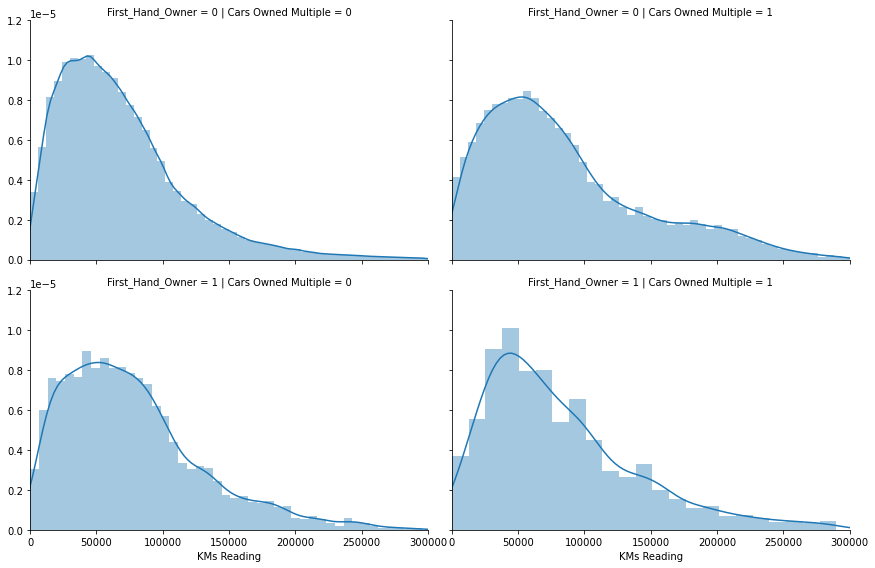

In [58]:
facet = sns.FacetGrid(invoice, row='First_Hand_Owner', col='Cars Owned Multiple', 
                      size=4, aspect=1.5)
fig = facet.map(sns.distplot, 'KMs Reading')
__ = fig.set(xlim=(0, 300000), ylim=(0, 1.2*1e-5))

#### Cleaning `'JobCard Date`, `JobCard Time`, `Invoice Date`, `Invoice Time` and `Gate Pass Time`

* Cleaning these values will enable time series analysis for customer prediction, understanding customer behaviour and assess how the business has been doing.

In [6]:
from itertools import product

In [7]:
from datetime import datetime
from datetime import timedelta

In [61]:
def convert_to_datetime(item):
    try:
        return datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
    except:
        print("Couldn't parse: {0}".format(item))
        assert False

In [62]:
invoice['JobCard DateTime'] = invoice['JobCard Date'] + " " + invoice['JobCard Time']
invoice['JobCard DateTime'] = invoice['JobCard DateTime'].apply(convert_to_datetime)

In [63]:
invoice['Gate Pass DateTime'] = invoice['JobCard Date'] + " " + invoice['Gate Pass Time']
invoice['Gate Pass DateTime'] = invoice['Gate Pass DateTime'].apply(convert_to_datetime)

In [64]:
invoice['Invoice DateTime'] = invoice['Invoice Date'] + " " + invoice['Invoice Time']
invoice['Invoice DateTime'] = invoice['Invoice DateTime'].apply(convert_to_datetime)

In [65]:
invoice['Total Time in seconds'] = invoice['Invoice DateTime'] - invoice['JobCard DateTime']
invoice['Total Time in seconds'] = invoice['Total Time in seconds'].apply(timedelta.total_seconds)

In [66]:
invoice.drop(invoice[ invoice['Total Time in seconds'] <= 0].index, axis=0, inplace=True)

In [67]:
invoice['Total time in days'] = invoice['Total Time in seconds']//(60*60*24)

* Creating a new feature `Response Time` which is more useful compared to `Total Time` as it keeps track of time between the customer requesting an order and the car being brought into the workshop.

In [68]:
invoice['Response Time in seconds'] = invoice['Gate Pass DateTime'] - invoice['JobCard DateTime']
invoice['Response Time in seconds'] = invoice['Response Time in seconds'].apply(timedelta.total_seconds)

In [69]:
invoice['Response Time in seconds'] = np.where(invoice['Response Time in seconds'] < 0, 
                                               invoice['Response Time in seconds'] + 60*60*24,
                                               invoice['Response Time in seconds'])

In [70]:
invoice['Response time in hours'] = invoice['Response Time in seconds']/(60*60)
invoice['Response time in days'] = invoice['Response Time in seconds']//(60*60*24)

* Let's look at the distribution of `Response Time` in hours.

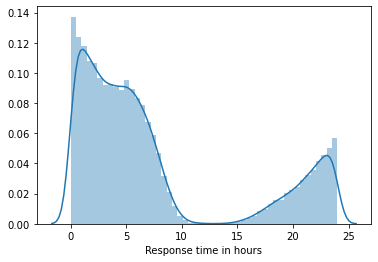

In [71]:
# plotting distribution of response time
mask = (invoice['Gate Pass Time'] != "00:00:00")
sns.distplot(invoice[mask]['Response time in hours'])

* The curve is U-shaped due to the fact that most workshops are closed during the night. Customers drop their cars during a comfortable time period.
* Let's plot the time when cars are dropped in to confirm this hypothesis.

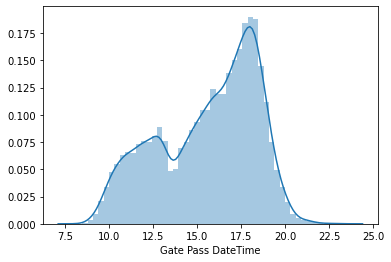

In [72]:
def get_seconds(dt_time):
#     x.to_pydatetime().time().hour * 60 + x.to_pydatetime().time().minute) * 60 + x.to_pydatetime().time().second
    hours = dt_time.to_pydatetime().time().hour * 60 * 60
    minutes = dt_time.to_pydatetime().time().minute * 60
    seconds = dt_time.to_pydatetime().time().second
    return hours + minutes + seconds

sns.distplot(invoice[mask]['Gate Pass DateTime'].apply(lambda x: get_seconds(x)/3600))

* Customers are more likely to drop their cars in the workshops in the evenings.
* A dip around 2 pm is observed, which may be due to lunch time in some workshops or customers not wanting to drop cars during that time.
<br><br>
* Plotting time taken in days for jobs

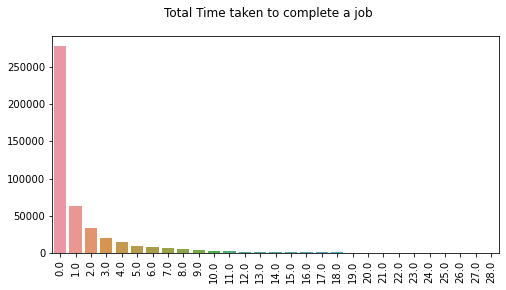

In [73]:
mask = invoice['Total time in days'] <= 28

_ = invoice[mask]['Total time in days'].value_counts()
__ = plt.figure(figsize=(8, 4))
fig = sns.barplot(x=_.index, y=_.values)
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Total Time taken to complete a job')

In [74]:
123

123

In [76]:
type()

numpy.ndarray

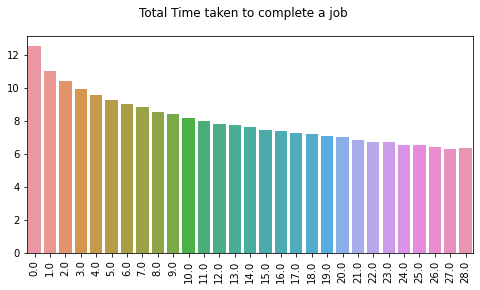

In [77]:
mask = invoice['Total time in days'] <= 28

_ = invoice[mask]['Total time in days'].value_counts()
__ = plt.figure(figsize=(8, 4))
fig = sns.barplot(x=_.index, y=pd.Series(_.values).apply(lambda x: np.log(x)))
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Total Time taken to complete a job')

* `Total Time` follows an exponential distribution. Most jobs are completed within 2 days but there exist jobs that take much longer than that.

In [71]:
invoice.rename(columns={'District': 'State', 'CITY': 'City', 'Area / Locality': 'District'}, inplace=True)

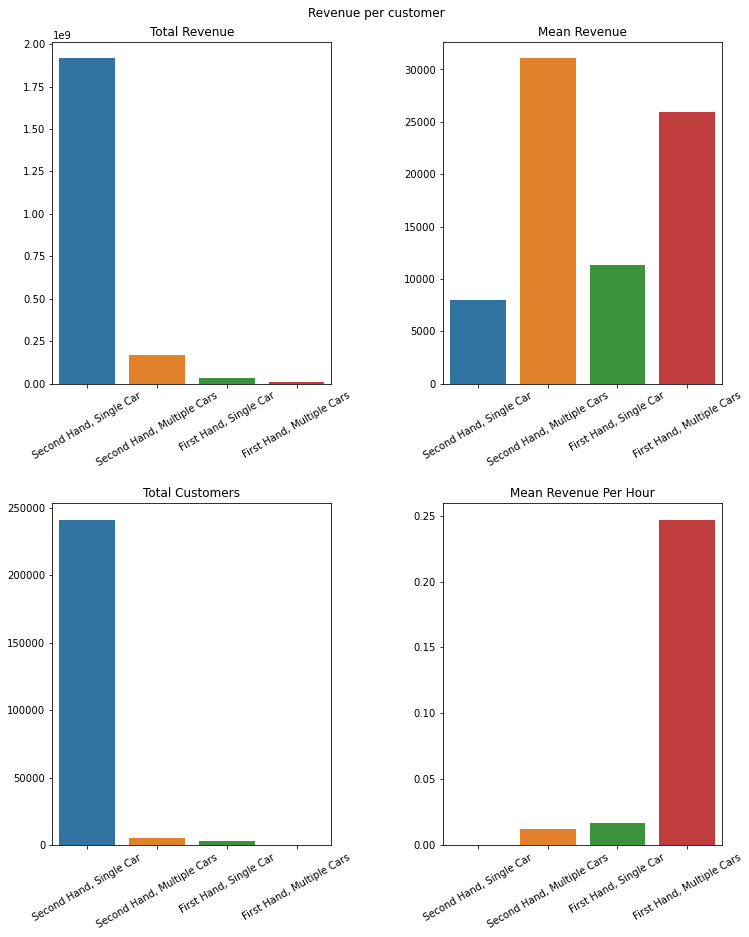

In [72]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
__ = plt.subplots_adjust(top=0.94, bottom=0.01, hspace=0.35, wspace=0.4)

labels = ['Second Hand, Single Car', 'Second Hand, Multiple Cars', 
          'First Hand, Single Car', 'First Hand, Multiple Cars']
titles = ['Total Revenue', 'Mean Revenue', 'Total Customers', 'Mean Revenue Per Hour']

for i, ax_ in enumerate(ax.ravel()):
    
    _ = []
    ax_.title.set_text(titles[i])

    for j, k in product([0, 1], [0, 1]):
        mask = (invoice['First_Hand_Owner'] == j) & (invoice['Cars Owned Multiple'] == k)
        if i == 0:
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum())
        elif i== 1:
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Customer No.'].nunique())
        elif i==2:
            _.append(invoice[mask]['Customer No.'].nunique())
        else:
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / \
                     (invoice[mask]['Customer No.'].nunique() * \
                          (invoice[mask]['Total Time in seconds'].sum()/3600 - invoice[mask]['Response time in hours'].sum())
                     )
                )

    _ = pd.Series(data=_, index=labels)

    fig_1 = sns.barplot(x=_.index, y=_.values, 
                      ax=ax_)
    __ = fig_1.set_xticklabels(labels=_.index, rotation=30)
    
__ = plt.suptitle("Revenue per customer")

* The `maximum business` is coming from customers that have a `single second hand` car.
* The `most luvrative oppurtunity` is serving a customer that has `multiple first hand cars`.
* Also note that although the `mean revenue` from multiple second hand car customers is `highest`, the `mean revenue per hour` is `highest` for those with `multiple first hand cars`.

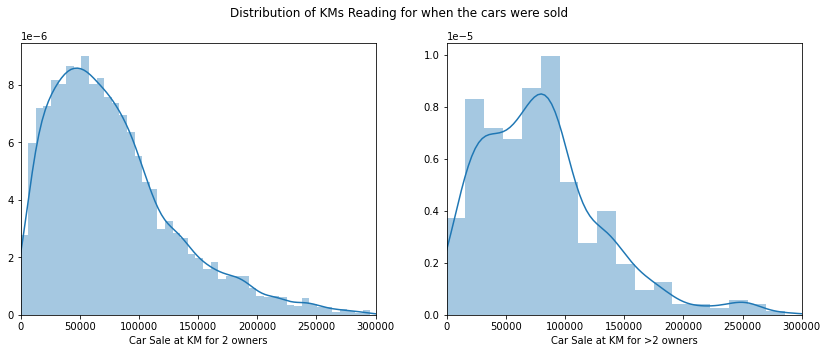

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
masks = [(invoice['First_Hand_Owner'] == 1) 
             & (invoice['Vehicle Owner Count'] == 2) 
             & (invoice['Car_Customer_Last_KM'] == invoice['KMs Reading']), 
         (invoice['First_Hand_Owner'] == 1) 
             & (invoice['Vehicle Owner Count'] > 2) 
             & (invoice['Car_Customer_Last_KM'] == invoice['KMs Reading']),
        ]
labels = ["Car Sale at KM for 2 owners", 
          "Car Sale at KM for >2 owners"]

for i, ax_ in enumerate(ax.ravel()):
    __ = ax_.set_xlim(0, 300000)
    fig_1 = sns.distplot(invoice[masks[i]]['Car_Customer_Last_KM'], 
                         ax=ax_, axlabel=labels[i])
__ = plt.suptitle("Distribution of KMs Reading for when the cars were sold")

* It's observed that if a person wants to buy a first hand car from someone, they prefer buying it at around `60,000`KM reading.
* On the other hand, those interested in buying second hand cars prefer to buy them at around `100,000`KM reading.
* From this information, we may be able to predict when a customer may consider selling their old vehicle.
* This may be transformed into an oppurtunity to offer an `exchange deal` or offer `long term service packages`.

### 1.3 JTD

In [74]:
check_null(jtd)

Total Columns: 5619484


,Number_Missing,% Missing,Missing?
Labor Value Number,3774033,67.159778,True
Material,51629,0.918750,True
Description,51629,0.918750,True
Target quantity UoM,51629,0.918750,True


In [75]:
mask = (jtd['Material'].isnull()) | (jtd['Description'].isnull()) | (jtd['Target quantity UoM'].isnull())
jtd.drop(jtd[mask].index, axis=0, inplace=True)

jtd.drop(columns=['Labor Value Number'], axis=1, inplace=True)

In [76]:
check_recurring(jtd)

,Column,Unique Values,Not Null Values,Ratio to Total Number,Has Null
4,Item Category,4,5567855,7.184095e-07,False
6,Target quantity UoM,4,5567855,7.184095e-07,False
1,Order Item,558,5567855,1.002181e-04,False
5,Order Quantity,3604,5567855,6.472870e-04,False
3,Description,58558,5567855,1.051716e-02,False
2,Material,126567,5567855,2.273173e-02,False
7,Net value,375642,5567855,6.746620e-02,False
0,DBM Order,936619,5567855,1.682190e-01,False


* JTD has been cleaned.
<br><br>
* `DBM Order` corresponds to the `Job Card No` in `Invoice`.
* Multiple entries in `JTD` mean that for most orders, multiple parts were used and each has been duly noted.
* `"SRV"` in `JTD['Material']` may refer to `Store Receipt Voucher`.

In [77]:
jtd['Target quantity UoM'].value_counts()

EA     2745660
MIN    2317562
L       504597
GRO         36
Name: Target quantity UoM, dtype: int64

Seem to be 'Each', 'Minimum', 'Litre' and 'Gross'

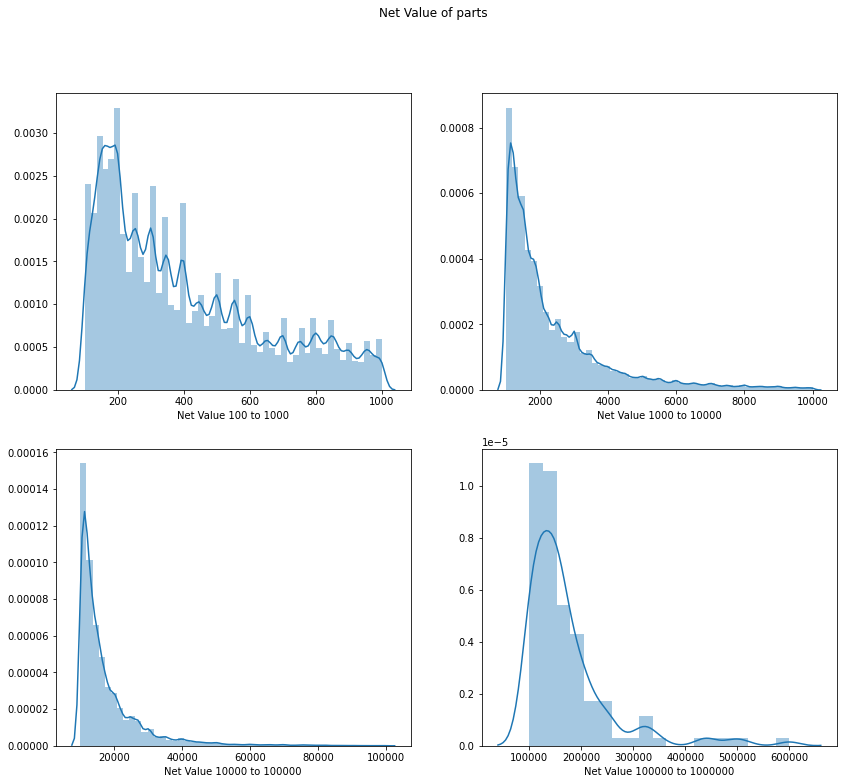

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

for i, ax_ in enumerate(ax.ravel()):
    
    start = 10**(2+i)
    mask = jtd['Net value'].between(start, start*10)
    fig_1 = sns.distplot(jtd[mask]['Net value'], 
                         ax=ax_, axlabel=f'Net Value {start} to {start*10}')

__ = plt.suptitle('Net Value of parts')

* `Net value` has an exponential distribution. This may help in clustering the different kind of repairs.
* Data in `UoM` and `Order Quantity` is very dirty and due to no contextual aid, they will not be considered.
* Instead, `Net Value` will be used as a substitute wherever applicable.

### Revenue based on Plant

In [79]:
revenue_plant = {}

for plant in invoice['Plant'].unique():
    revenue_plant[plant] = invoice[invoice['Plant'] == plant]['Total Amt Wtd Tax.'].sum()

revenue_plant = pd.Series(revenue_plant).sort_values(ascending=False)

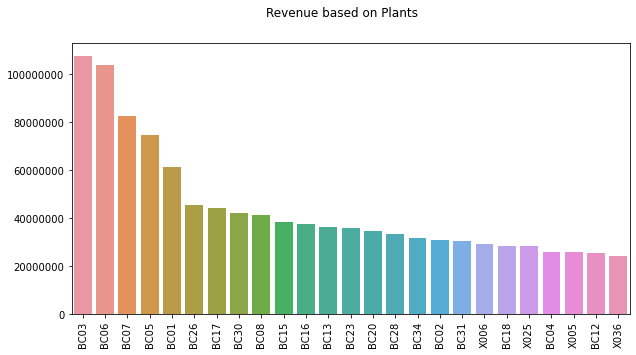

In [80]:
_ = plt.figure(figsize=(10, 5))

from_ = 0
to_ = from_ + 25

fig = sns.barplot(x=revenue_plant.iloc[from_:to_].index, 
                y=revenue_plant.iloc[from_:to_].values,
                orient='v')

__ = plt.ticklabel_format(style='plain', axis='y')
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Revenue based on Plants')

### Revenue based on State

In [81]:
revenue_state = {}

for state in invoice['State'].unique():
    revenue_state[state] = invoice[invoice['State'] == state]['Total Amt Wtd Tax.'].sum()

revenue_state = pd.Series(revenue_state).sort_values(ascending=False)

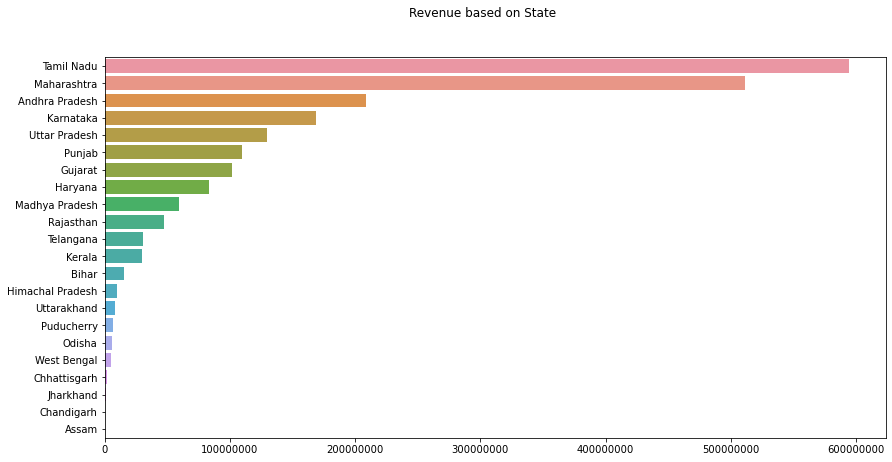

In [82]:
_ = plt.figure(figsize=(14, 7))

fig = sns.barplot(y=revenue_state.index, 
                x=revenue_state.values, 
                orient='h')

__ = plt.ticklabel_format(style='plain', axis='x')
__ = plt.suptitle("Revenue based on State")

### Mean revenue for plants in states

In [83]:
revenue_state_mean = revenue_state.copy()

for state in revenue_state_mean.index:
    revenue_state_mean[state] /= invoice[ invoice['State'] == state]['Plant'].nunique()

revenue_state_mean.sort_values(ascending=False, inplace=True)

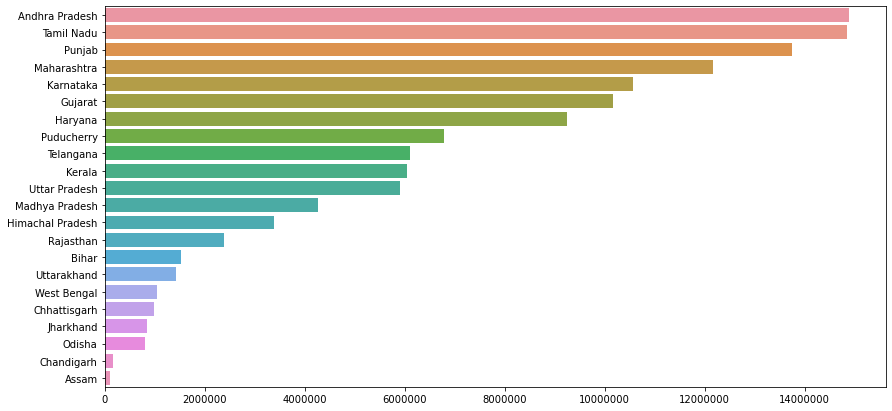

In [84]:
_ = plt.figure(figsize=(14, 7))

_ = sns.barplot(y=revenue_state_mean.index, 
                x=revenue_state_mean.values, 
                orient='h')

_ = plt.ticklabel_format(style='plain', axis='x')

In [85]:
stack_df = pd.DataFrame(np.zeros((242, 22)), 
                        index=invoice['Plant'].unique(), 
                        columns=invoice['State'].unique())

In [86]:
for plant in invoice['Plant'].unique():
    mask = (invoice['Plant'] == plant)
    state = invoice[mask]['State'].iloc[0]
    stack_df.at[plant, state] = invoice[mask]['Total Amt Wtd Tax.'].sum()

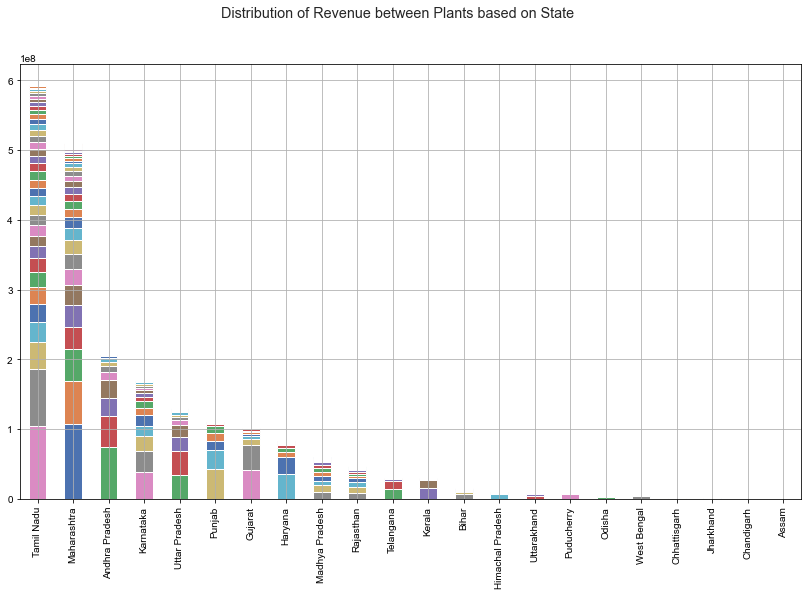

In [87]:
stack_df = stack_df.sort_values(by=[i for i in stack_df.columns], ascending=False)
order = revenue_state.index
fig, ax = plt.subplots(figsize=(14, 8))

sns.set()
__ = stack_df.T.loc[order] \
            .plot(kind='bar', stacked=True, 
                  legend=False, ax=ax)
__ = plt.suptitle("Distribution of Revenue between Plants based on State")

* Plotting `KMs reading` vs `Type of Order`

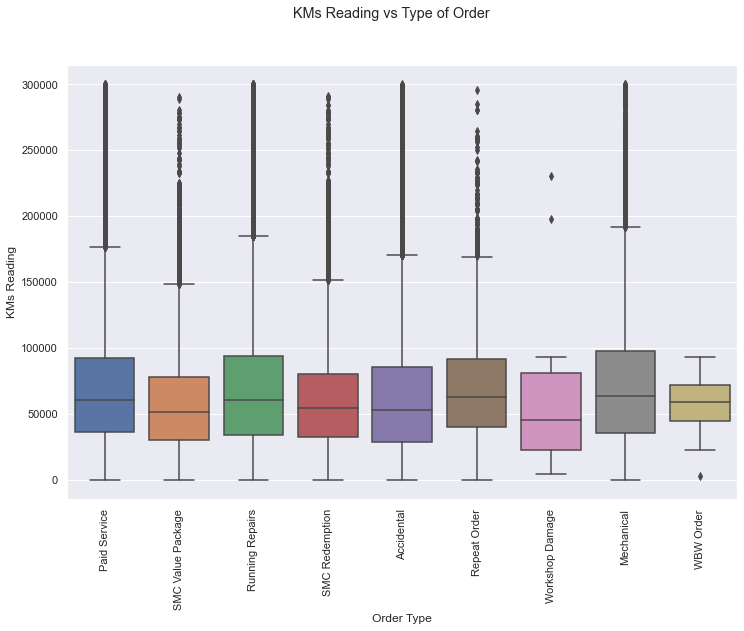

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

fig_1 = sns.boxplot(x='Order Type', y='KMs Reading', 
                    data=invoice)

__ = plt.xticks(rotation=90)
__ = plt.suptitle('KMs Reading vs Type of Order')

* There doesn't seem to be much difference beteen `KMs Reading` based on order types.
* Let's see how `Revenue` is affected wrt `KMs Reading`.

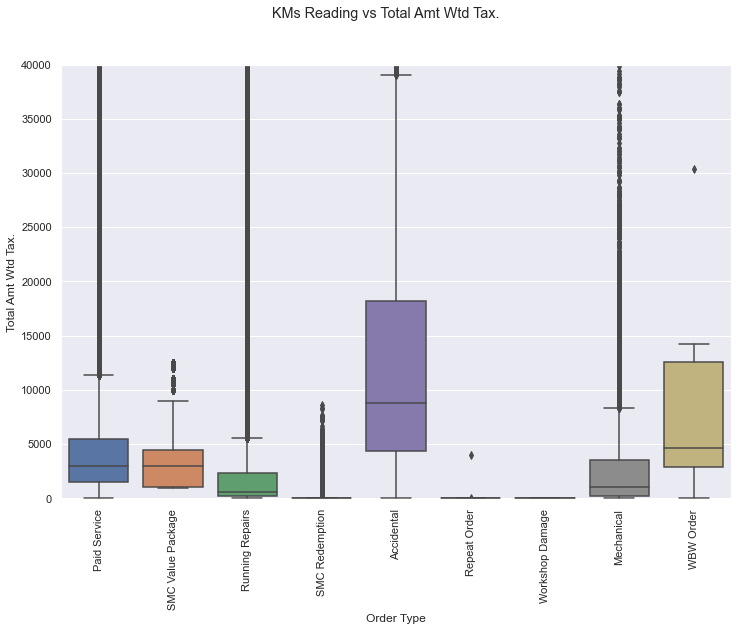

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

__ = ax.set_ylim(-100, 40000)

fig_1 = sns.boxplot(x='Order Type', y='Total Amt Wtd Tax.', 
                    data=invoice, ax=ax)

__ = plt.xticks(rotation=90)
__ = plt.suptitle('KMs Reading vs Total Amt Wtd Tax.')

* As expected, `Accidental` order type has the highest `Amount Paid`.
* `SMC Redemption` has `0` amount paid in most cases. This may be due to the SMC package covering most kinds of repairs.
<br><br>
* Let's see how the `number of parts used` is affected by `Order Type`.

In [90]:
invoice['Is Old'] = (invoice['KMs Reading'] >= 180000).astype(int)

In [91]:
inv_jtd_inner = pd.merge(left=invoice, right=jtd, how='inner', left_on='Job Card No', right_on='DBM Order')

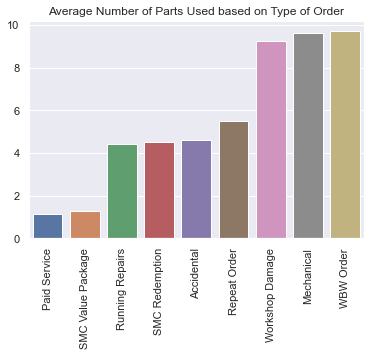

In [92]:
_ = []

for order in inv_jtd_inner['Order Type'].unique():
    mask = (inv_jtd_inner['Order Type'] == order)
    
    _.append(len(inv_jtd_inner[mask]) / inv_jtd_inner[mask]['Job Card No'].nunique())

_ = sns.barplot(x=inv_jtd_inner['Order Type'].unique(),
                y=sorted(_))
_ = plt.xticks(rotation=90)
_ = plt.title('Average Number of Parts Used based on Type of Order')

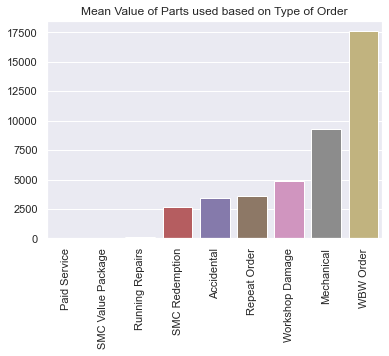

In [93]:
_ = []

for order in inv_jtd_inner['Order Type'].unique():
    mask = (inv_jtd_inner['Order Type'] == order)
    
    _.append(inv_jtd_inner[mask]['Net value'].sum() / inv_jtd_inner[mask]['Job Card No'].nunique())

_ = sns.barplot(x=inv_jtd_inner['Order Type'].unique(),
                y=sorted(_))
_ = plt.xticks(rotation=90)
_ = plt.title('Mean Value of Parts used based on Type of Order')

In [94]:
invoice['Revenue per hour'] = invoice['Total Amt Wtd Tax.'] / (invoice['Total Time in seconds']/3600)

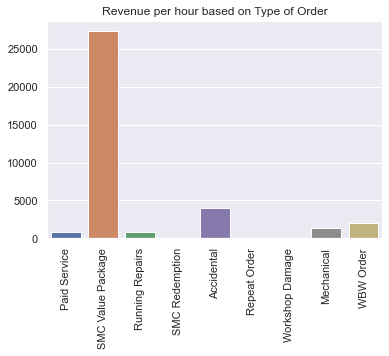

In [95]:
_ = []

for order in invoice['Order Type'].unique():
    mask = (invoice['Order Type'] == order)
    
    _.append(invoice[mask]['Revenue per hour'].sum() / invoice[mask]['Job Card No'].nunique())

_ = sns.barplot(x=invoice['Order Type'].unique(),
                y=_)
_ = plt.xticks(rotation=90)
_ = plt.title('Revenue per hour based on Type of Order')

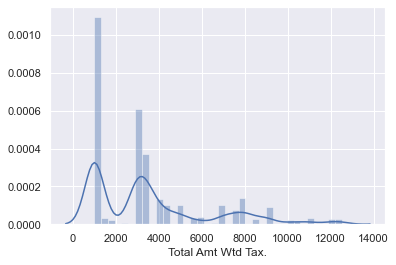

In [96]:
sns.distplot(invoice[invoice['Order Type'] == 'SMC Value Package']['Total Amt Wtd Tax.'])

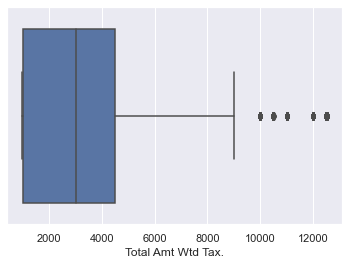

In [97]:
sns.boxplot(invoice[invoice['Order Type'] == 'SMC Value Package']['Total Amt Wtd Tax.'])

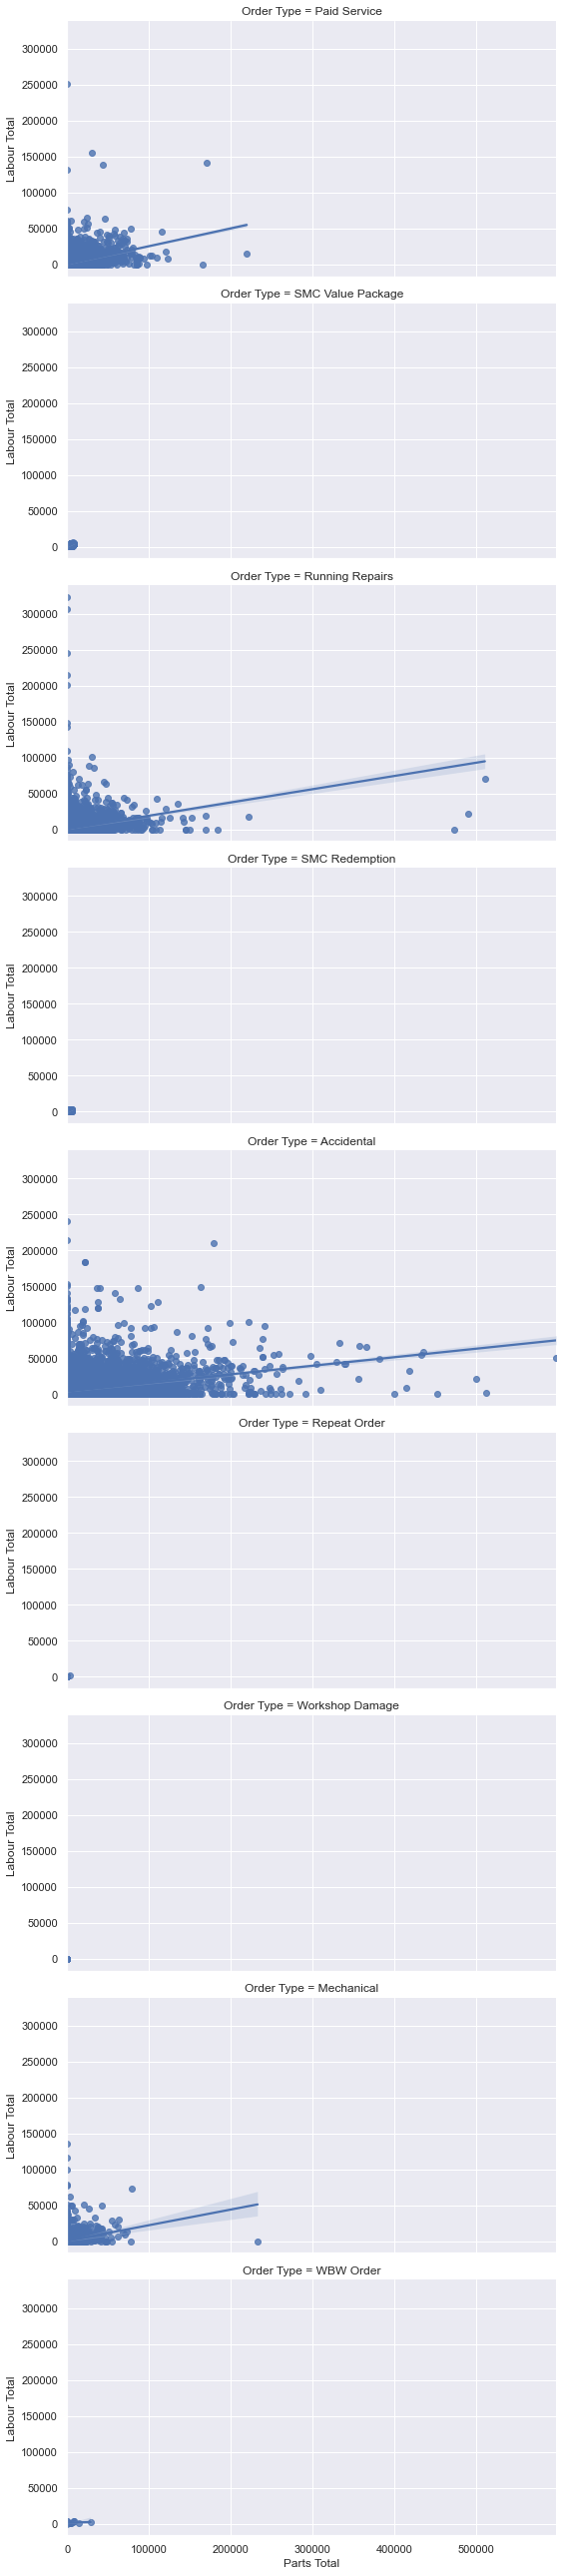

In [98]:
# checking if any relation exists between 'parts cost' and 'labour cost'

facet = sns.FacetGrid(invoice, row='Order Type', size=4, aspect=2)
figure = facet.map(sns.regplot, 'Parts Total', 'Labour Total')

* There's a clear positive correlation of parts with labour costs, but labour costs do not increase at the same scale as parts costs.

In [99]:
df_parts_to_labour = pd.DataFrame(np.zeros((invoice['Make'].nunique(), invoice['Order Type'].nunique())), 
                                  columns=invoice['Order Type'].unique(), 
                                  index=invoice['Make'].unique())

for make, order in product(invoice['Make'].unique(), 
                           invoice['Order Type'].unique()):
    mask = (invoice['Make'] == make) & (invoice['Order Type'] == order)
    df_parts_to_labour.at[make, order] = invoice[mask]['Parts Total'].sum() / invoice[mask]['Labour Total'].sum()

df_parts_to_labour.fillna(0, inplace=True)
# df_parts_to_labour.head()

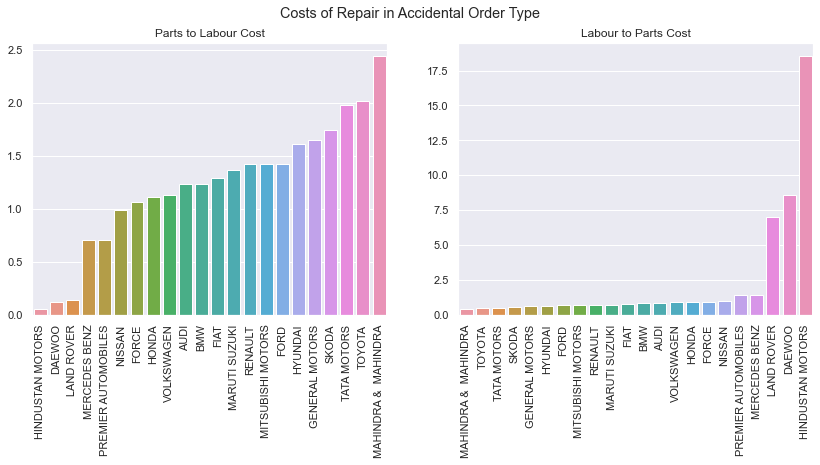

In [100]:
# Plotting Parts:Labour and Labour:Parts costs to understand favorable and unfavorable jobs

_ = df_parts_to_labour['Accidental'].sort_values()
_ = _[_>0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

fig_1 = sns.barplot(x=_.index, y=_.values, ax=ax[0])
__ = fig_1.set_xticklabels(labels=_.index, rotation=90)
__ = fig_1.set_title('Parts to Labour Cost')

_ = (1/_).sort_values()
fig_2 = sns.barplot(x=_.index, y=_.values, ax=ax[1])
__ = fig_2.set_xticklabels(labels=_.index, rotation=90)
__ = fig_2.set_title('Labour to Parts Cost')

__ = plt.suptitle('Costs of Repair in Accidental Order Type')

* From the graphs, it's observed that `Labour:Parts` costs is high in cases of luxury vehicles or old/obsolete vehicles.
* On the other hand, those with a higher `Parts:Labour` cost ratio are more lucrative due to lower labour costs.
* The trend was found to be the same when `Parts:Labour * Repair Time` was plotted.

In [101]:
invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime()).dt.month_name()

0         December
1          January
2          January
3          January
4          January
            ...   
484685        June
484686        June
484687        June
484688        June
484689        June
Name: JobCard DateTime, Length: 484689, dtype: object

In [102]:
invoice['Year'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().year)
invoice['Month'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().month)
invoice['Month Name'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime()).dt.month_name()
invoice['Day'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().day)
invoice['Day Name'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime()).dt.day_name()
invoice['Hour'] = invoice['JobCard DateTime'].apply(lambda x: x.to_pydatetime().hour)

In [4]:
years = sorted(invoice['Year'].unique())
months = sorted(invoice['Month Name'].unique(), 
                        key=lambda x: invoice[invoice['Month Name']==x]['Month'].iloc[0])

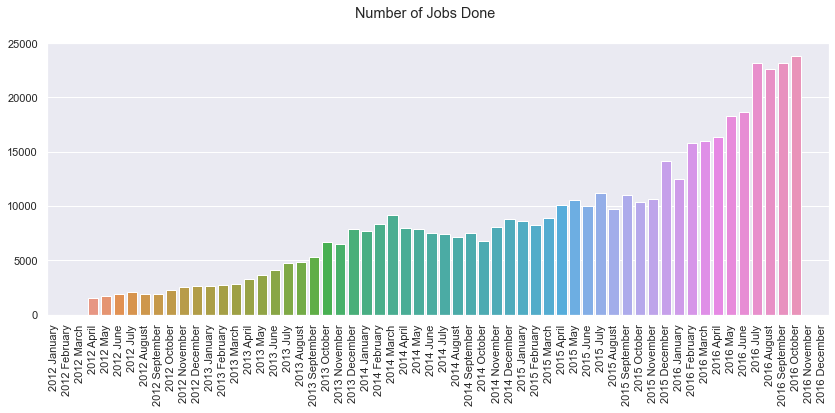

In [104]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Job Card No'].nunique())
        except:
            continue

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                         list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Number of Jobs Done')

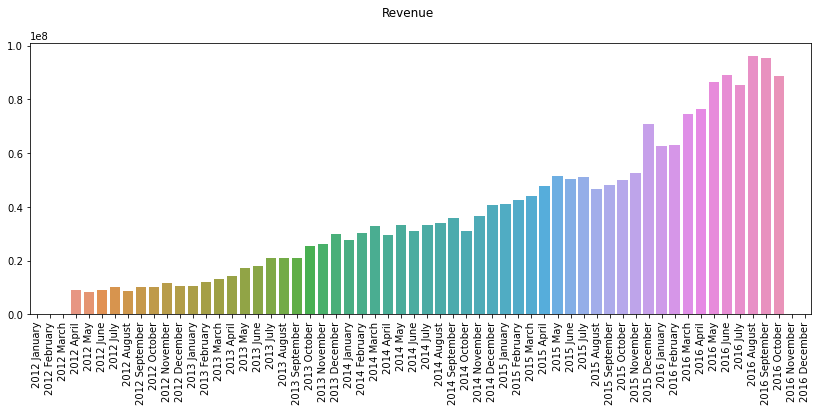

In [10]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Revenue')

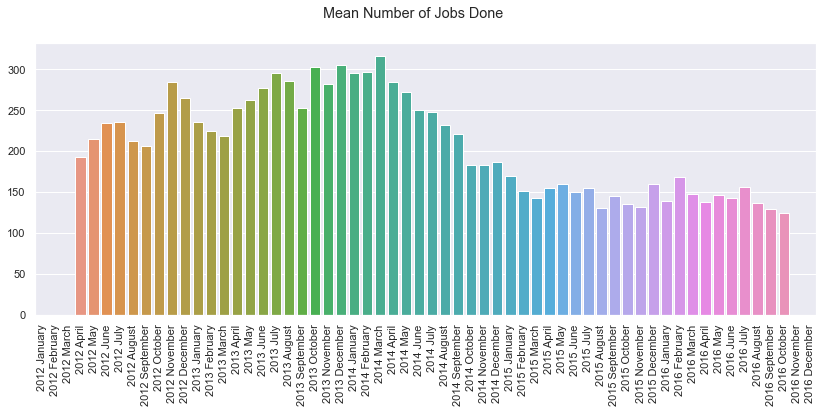

In [106]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Job Card No'].nunique() / invoice[mask]['Plant'].nunique())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Mean Number of Jobs Done')

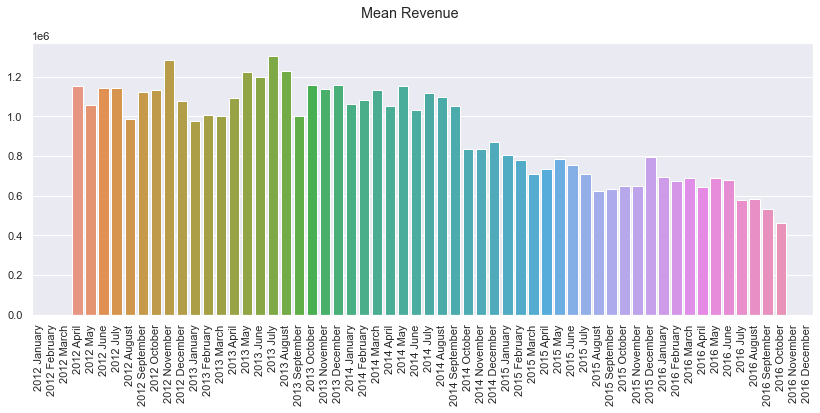

In [107]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Total Amt Wtd Tax.'].sum() / invoice[mask]['Plant'].nunique())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Mean Revenue')

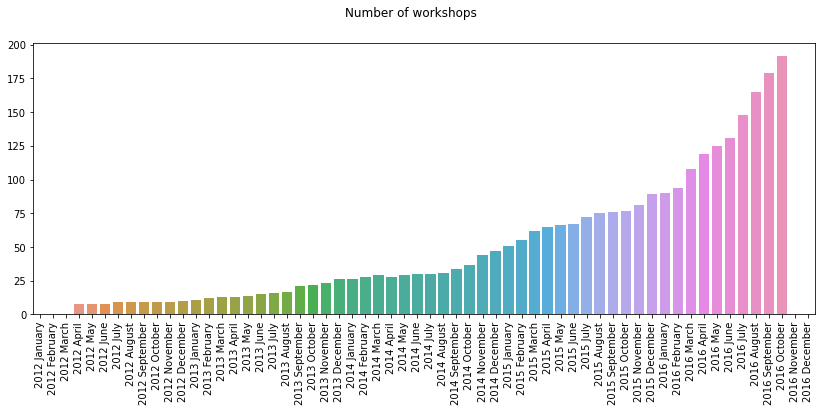

In [9]:
_ = []

for year in years:
    for month in months:
        try:
            mask = (invoice['Year'] == year) & (invoice['Month Name'] == month)
            _.append(invoice[mask]['Plant'].nunique())
        except:
            _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=list(map(lambda x: ' '.join([str(x[0]), x[1]]), 
                                    list(product(years, months)))),
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Number of workshops')

In [108]:
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

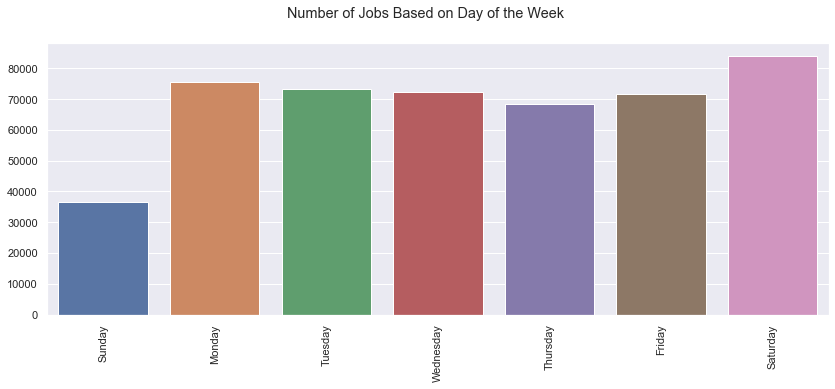

In [109]:
_ = []

for weekday in weekdays:
    try:
        mask = (invoice['Day Name'] == weekday)
        _.append(invoice[mask]['Job Card No'].nunique())
    except:
        _.append(0)

__ = plt.figure(figsize=(14, 5))
fig_1 = sns.barplot(y=_, x=weekdays,
                   )
__ = plt.xticks(rotation=90)
__ = plt.suptitle('Number of Jobs Based on Day of the Week')

* Day with most new jobs is `Saturday` whereas the quietest day is `Sunday`.
* Low number of jobs on `Sunday` may be due to lesser working hours. Let's investigate this hypothesis.

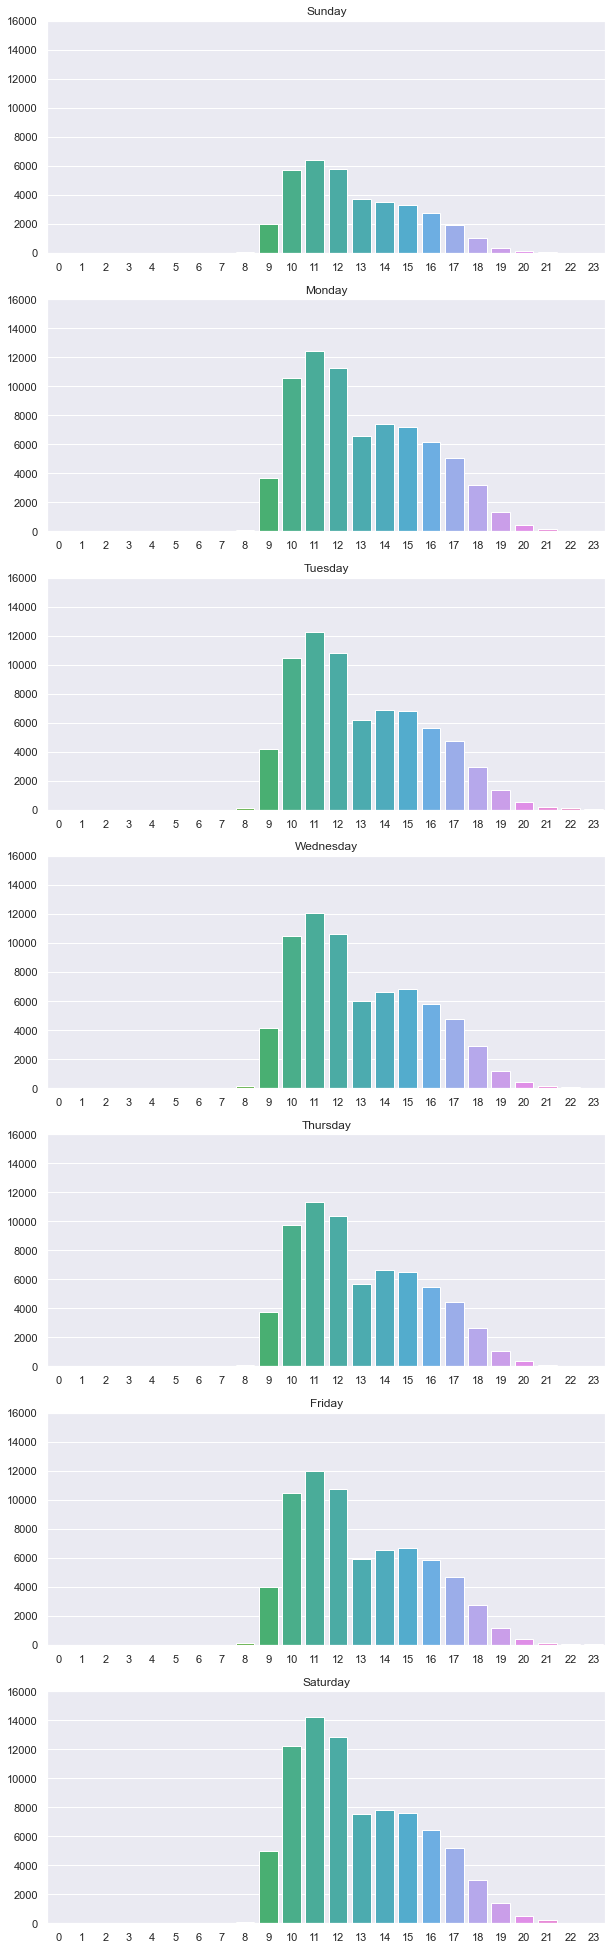

In [110]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(10, 35))

for i, day in enumerate(weekdays):
    _ = []
    
    for hour in range(0, 24):
        try:
            mask = (invoice['Day Name'] == day) & (invoice['Hour'] == hour)
            _.append(invoice[mask]['Job Card No'].nunique())
        except:
            _.append(0)
    
    __ = ax[i].set_ylim(0, 16000)
    fig_1 = sns.barplot(x=list(range(0, 24)), y=_, ax=ax[i])
    __ = fig_1.set_title(day)

* The working hours are the same on `Sunday` which may mean that the difference in trend may be due to low number of customers or a plant not doing any jobs on `Sunday`.
* Let's see if this hypothesis holds true.

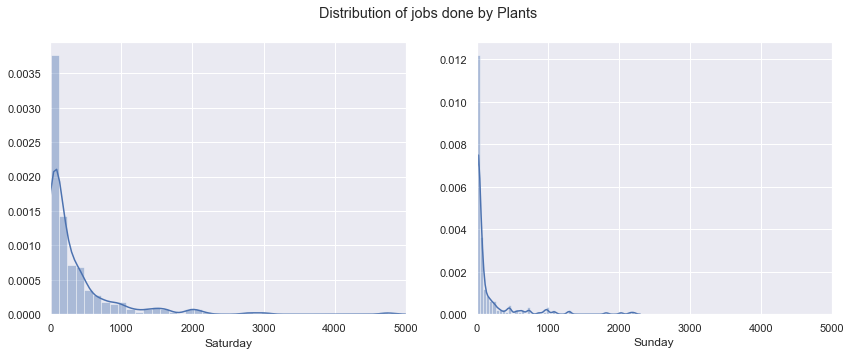

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

__ = ax[0].set_xlim(0, 5000)
__ = ax[1].set_xlim(0, 5000)

__ = sns.distplot(invoice[invoice['Day Name'] == 'Saturday']['Plant'].value_counts().values,
                 ax=ax[0], axlabel='Saturday')
__ = sns.distplot(invoice[invoice['Day Name'] == 'Sunday']['Plant'].value_counts().values,
                 ax=ax[1], axlabel='Sunday')

__ = plt.suptitle('Distribution of jobs done by Plants')

* It can be seen that most plants do not provide services on `Sunday`. This could be due to `low demand in that area`, hence the change in trend in the daily new jobs.
* Note that the peak for `Sunday` has a higher value, which means that the total number of jobs done across the country are low.

In [112]:
invoice.to_csv("redacted/processed data/invoice_check1.csv", index=False)

# Assimilating features into parent dataframes

In [134]:
# invoice.to_csv('invoice_check2.csv', index=False)
# customer_data.to_csv('customer_data_check2.csv', index=False)
# jtd.to_csv('jtd_check2.csv', index=False)
# plant_master.to_csv('plant_master_check2', index=False)

In [2]:
invoice = pd.read_csv('invoice_check2.csv')
customer_data = pd.read_csv('customer_data_check2.csv')
jtd = pd.read_csv('jtd_check2.csv')
plant_master = pd.read_csv('plant_master_check2')

* Checking if 'Total Amt Wtd Tax.' contains sum of 'Net value' for the order.

In [113]:
a = set(jtd['DBM Order'].unique())
b = set(invoice['Job Card No'].unique())

a_common_b = a.intersection(b)

In [114]:
for order in a_common_b:
    if random.random() > 0.9:
        invoice[invoice['Job Card No'] == order][['Total Amt Wtd Tax.']]
        jtd[jtd['DBM Order']==order]['Net value'].sum()
        jtd[jtd['DBM Order']==order]
        break

,Total Amt Wtd Tax.
217815,5260.14


5260.139999999999

,DBM Order,Order Item,Material,Description,Item Category,Order Quantity,Target quantity UoM,Net value
4099391,21,10,FFSBULB002,"BULB 100/90W,12V,P43T",P002,1.0,EA,122.28
4099392,21,20,1AM09471M12073,"BULB(12V,5W)",P002,3.0,EA,137.93
4099393,21,30,PAINT_SRV,PAINTING REAR RH DOOR - METALLIC,P001,1700.0,MIN,1699.97
4099394,21,40,PAINT_SRV,PAINTING QUARTER PANEL RHS - METALLIC,P001,1400.0,MIN,1399.98
4099395,21,50,ACCT_SRV,DENTING REAR RH DOOR,P001,650.0,MIN,649.99
4099396,21,60,ACCT_SRV,MAJOR DENTING PER PANEL,P001,1100.0,MIN,1099.99
4099397,21,70,ACCT_SRV,REMOVE/REPLACE FRONT/REAR DOOR,P001,125.0,MIN,125.00
4099398,21,90,ACCT_SRV,REMOVE & REFIT PANEL (DOOR/DICKY/FENDOR),P001,25.0,MIN,25.00


* Both contain the same value. `JTD` doesn't contain other features that may aid in clustering, it won't be merged.
* Also, `customer_data` doesn't ccontain information related to orders, hence, won't be merged.

### Converting plants to lat long

In [165]:
coordinates = [[19.215091, 72.976102], [18.594586, 73.741557], [19.985644, 73.783781], 
[17.468244, 78.446192], [17.495588, 78.317821], [13.059647, 80.258792], 
[13.072326, 80.191837], [20.383214, 72.909670], [19.120404, 72.863430], 
[17.383226, 78.429198], [21.194438, 72.788932], [12.937959, 77.700972], 
[13.058978, 80.256487], [14.443713, 79.985864], [11.046197, 76.947989], 
[18.541256, 73.934682], [28.682951, 77.367394], [10.020293, 76.310958], 
[28.519907, 77.458722], [28.464783, 77.306076], [18.590924, 73.742870], 
[19.010331, 73.012065], [21.152048, 79.138903], [30.907856, 75.840015], 
[28.577476, 77.315592], [28.619356, 77.388404], [30.716639, 76.706718], 
[13.023060, 77.540973], [30.868185, 75.858690], [30.665652, 76.842362], 
[18.664167, 73.787218], [19.236526, 72.967250], [12.938083, 77.700996], 
[13.023436, 80.206797], [19.263948, 72.871374], [12.931297, 77.685583], 
[11.920081, 79.763021], [12.985178, 79.292475], [11.922611, 79.480958], 
[11.406618, 79.684685], [11.631934, 79.550238], [12.796235, 78.729574], 
[18.463690, 74.378622], [16.698133, 74.240553], [18.827318, 74.373021], 
[11.001132, 76.937396], [11.670403, 78.162201], [10.774720, 79.125670], 
[11.102379, 77.344011], [10.762336, 78.627876], [30.824970, 75.148289], 
[18.759251, 73.823438], [18.553940, 73.806163], [19.095085, 74.749411], 
[30.714002, 76.808413], [10.624270, 77.127809], [12.141260, 78.139100], 
[13.922335, 75.569142], [19.878281, 75.379643], [18.593123, 73.830530], 
[9.943752, 78.150047], [15.815775, 78.035466], [13.201257, 80.143801], 
[28.964472, 77.693597], [21.234043, 81.592462], [10.379781, 77.994315], 
[28.916796, 76.579395], [28.596279, 76.657244], [8.660852, 77.714958], 
[8.188992, 77.398469], [8.811578, 78.122350], [20.292700, 74.123481], 
[11.048776, 77.049611], [9.943745, 78.150054], [28.909185, 77.239768], 
[15.513622, 80.046712], [16.996115, 81.775023], [16.512709, 80.672523], 
[12.991121, 76.085938], [29.014443, 77.047267], [22.041446, 78.922925], 
[30.103863, 78.286623], [12.334520, 76.595001], [14.662062, 77.581432], 
[29.146466, 75.726646], [10.447792, 77.540560], [13.625373, 79.429566], 
[30.129938, 74.205596], [20.013358, 73.741297], [18.604253, 74.686718], 
[27.219729, 77.942320], [27.177240, 78.360547], [13.119256, 78.131198], 
[21.122816, 79.037696], [9.560700, 76.515438], [17.245681, 80.103210], 
[17.143359, 79.623205], [16.810541, 75.702592], [12.676621, 79.986321], 
[31.351231, 76.762500], [20.701960, 76.965088], [22.690971, 75.898309], 
[22.713762, 75.894200], [27.599951, 75.155787], [31.414733, 76.339531], 
[19.973527, 73.778184], [18.122815, 75.017369], [12.854804, 74.840461], 
[27.156765, 75.725023], [11.325748, 77.689803], [22.994026, 76.086571], 
[20.766216, 78.599347], [13.095066, 80.169326], [11.039454, 76.951105], 
[31.613187, 74.925003], [25.626872, 85.085310], [12.969948, 74.805082], 
[23.212042, 77.419244], [26.222503, 78.181232], [25.564749, 83.978198], 
[15.813598, 74.493736], [25.477464, 85.709141], [25.199412, 86.973372], 
[10.039752, 76.335928], [23.260933, 77.457581], [25.304898, 82.984718], 
[24.477630, 74.863069], [10.761515, 79.631465], [30.828280, 76.877577], 
[27.563577, 81.587277], [27.385408, 79.591334], [13.091416, 80.108287], 
[20.374290, 78.111287], [26.984754, 75.773320], [32.109171, 77.151527], 
[25.220233, 84.269580], [15.400968, 75.077474], [18.497634, 73.958764], 
[15.268559, 76.386584], [18.408763, 76.560360], [13.144988, 79.898518], 
[24.919335, 79.583587], [23.314035, 75.064539], [30.697978, 76.783987], 
[24.587795, 73.712452], [26.174892, 78.145045], [26.295593, 72.989407], 
[26.560438, 74.799727], [28.100993, 75.384763], [28.047878, 73.281105], 
[25.120276, 75.858548], [18.447911, 73.858109], [17.485031, 78.356446], 
[17.353625, 78.555615], [27.345001, 75.937612], [10.390228, 78.801130], 
[19.615905, 74.181753], [25.019248, 73.855047], [17.286801, 76.821525], 
[19.880054, 75.322577], [25.755273, 86.026432], [12.780715, 77.770958], 
[10.939788, 75.978502], [20.083475, 73.917100], [23.135461, 83.181954], 
[29.444485, 77.304149], [16.323713, 80.436221], [14.737688, 78.547977], 
[17.000160, 82.244454], [28.876011, 78.469805], [24.690539, 78.434970], 
[25.491975, 78.575221], [27.568598, 78.053021], [27.962835, 79.736308], 
[25.432569, 86.087629], [20.554704, 74.510166], [20.009086, 73.817150], 
[24.574223, 80.836938], [27.906422, 78.103786], [20.501543, 76.202096], 
[28.976689, 79.394214], [17.644373, 75.915518], [29.242850, 78.986767], 
[29.217579, 79.520630], [29.309947, 79.199294], [27.368420, 75.567944], 
[22.697011, 88.416636], [20.901606, 85.169262], [20.328699, 86.591131], 
[11.244325, 78.166536], [25.167565, 83.616867], [18.403062, 77.104115], 
[10.971729, 78.060811], [20.304008, 85.854455], [26.483737, 76.682708], 
[28.065790, 76.101525], [30.312544, 76.335592], [26.404586, 74.662197], 
[23.454963, 75.423044], [22.851981, 88.425937], [24.101683, 88.280377], 
[26.560113, 88.726050], [21.167410, 72.795416], [27.709639, 74.474621], 
[25.023428, 72.251698], [24.788020, 84.999158], [17.976961, 73.890391], 
[23.799489, 86.433914], [27.563804, 76.641566], [28.241500, 75.650025], 
[26.425201, 92.001417], [21.866987, 83.966052], [10.579775, 77.300519], 
[22.275410, 73.144235], [23.587729, 72.369977], [23.232012, 72.504059], 
[10.996377, 76.995848], [9.560003, 76.514840], [24.895737, 74.620020], 
[21.820251, 84.952562], [27.618032, 75.126050], [21.126074, 73.418261], 
[22.357303, 73.166835], [25.330150, 83.028002], [22.779050, 88.323619], 
[22.227799, 84.766025], [20.976318, 86.005137], [28.906635, 77.636125], 
[9.217204, 78.487588], [18.650802, 78.112990], [30.682212, 76.833204], 
[22.694486, 72.873803], [20.389099, 72.916078], [26.496433, 80.318001], 
[13.010240, 80.215650], [25.756723, 84.168661], [26.139994, 85.359823], 
[29.152618, 79.143005], [22.782812, 75.905759], [18.595437, 73.724380], 
[19.928281, 73.871603], [14.443414, 79.985945]]

In [166]:
plants = ['BC01 THANE THANE THANE Maharashtra 400607',
'BC02 PUNE PUNE PUNE Maharashtra 411021',
'BC03 NASHIK NASIK PUNE Maharashtra 422001',
'BC04 BALANAGAR BALANAGAR Hyderabad Andhra Pradesh 500037',
'BC05 MADEENAGUDA MADINAGUDA HYDERABAD Andhra Pradesh 500050',
'BC06 GUINDY GUINDY CHENNAI Tamil Nadu 600032',
'BC07 NERKUNDRAM CHENNAI CHENNAI Tamil Nadu 600107',
'BC08 VAPI VAPI VAPI Gujarat 396195',
'BC11 ANDHERI ANDHERI(E) MUMBAI Maharashtra 400093',
'BC12 HYDERABAD L B NAGAR LB NAGAR HYDERABAD Andhra Pradesh 500074',
'BC13 SURAT UDHANA BHESTAN SURAT Gujarat 395023',
'BC15 BELLANDUR - BANGALORE BELLANDUR BENGALURU Karnataka 560103',
'BC16 AMBATTUR - CHENNAI AMBATTUR CHENNAI Tamil Nadu 600053',
'BC17 NELLORE NELLORE NELLORE Andhra Pradesh 524002',
'BC18 COIMBATORE K.PALAYAM COIMBATORE Tamil Nadu 641030',
'BC19 HADAPSAR - PUNE HADAPSAR PUNE Maharashtra 411014',
'BC20 MOHAN NAGAR - GAZIABAD SAHIBABAD SAHIBABAD Uttar Pradesh 201007',
'BC21 EDAPPALLY - KOCHI EDAPPALLY ERNAKULAM Kerala 682024',
'BC22 GREATER NOIDA GR NOIDA GREATER NOIDA Uttar Pradesh 201306',
'BC23 FARIDABAD 1 FARIDABAD faridabad Haryana 121003',
'BC24 HINJAWADI – PUNE HINJEWADI PUNE Maharashtra 411057',
'BC25 NERUL - NAVI MUMBAI NERUL NAVI MUMBAI Maharashtra 400706',
'BC26 NAGPUR NAGPUR NAGPUR Maharashtra 440008',
'BC27 GT ROAD - LUDHIANA LDH LUDHIANA Punjab 141001',
'BC28 NOIDA - 63 NOIDA NOIDA Uttar Pradesh 201301',
'BC29 NOIDA - 05 NOIDA NOIDA Uttar Pradesh 201301',
'BC30 SAS NAGAR - MOHALI MOHALI MOHALI Punjab 160055',
'BC31 YESHWANTPUR - BANGALORE YESWANTHPUR Bnaglore Karnataka 560022',
'BC32 GILL ROAD - LUDHIANA GILL ROAD LUDHIANA Punjab 141001',
'BC33 PANCHKULLA PANCHKULA panchkula Haryana 134113',
'BC34 PIMPRI - PUNE CHINCHWAD PUNE Maharashtra 411019',
'X001 X001 - AUTO PLANET WHEELS THANE THANE Maharashtra 400607',
'X003 X003 - Om Sri Satya Sai Automo PANATHUR BANGALORE Karnataka 560087',
'X005 X005 - KLN MOTORS EKKATTUTHANGAL CHENNAI Tamil Nadu 600032',
'X006 X006 - A.M.MOTORS MIRAROAD EAST miraroad Maharashtra 401107',
'X007 X007 - OM SRI SATYA SAI AUTOMO SEEGEHALLI BANGALORE Karnataka 560067',
'X008 X008- AAKASH AUTO (Puducherry) PUDUCHERRY PUDUCHERRY Puducherry 605110',
'X010 X010 - LVM MOTORS SIPCOT RANIPET Tamil Nadu 632403',
'X011 X011- AAKASH AUTO (Villupuram) VILLUPURAM villupuram Tamil Nadu 605602',
'X012 X012 - SR CAR CARE CHIDAMBARAM chidambaram Tamil Nadu 608001',
'X013 X013 - SAI AUTO WORKS NEYVELI NEYVELI Tamil Nadu 607803',
'X014 X014 - NANGAN MOTORS PVT LTD. AMBUR AMBUR Tamil Nadu 635802',
'X016 X016 - KHUTWAD MOTORS DAUND PUNE Maharashtra 412203',
'X017 X017 - HEM KIRAN DIESELS KLP KOLHAPUR Maharashtra 416001',
'X018 X018 - EXPRESS WHEELS AUTO SER SHIRUR SHIRUR Maharashtra 412210',
'X020 X020 - SURYABALA SERVICE R.S PURAM COIMBATORE Tamil Nadu 641001',
'X021 X021 - THE TRUE SAI MOTORSS HASTHAMPATTY Salem Tamil Nadu 636007',
'X022 X022 - ARASU CAR ACCESSORIES PUDUKOTTAI THANJAVUR Tamil Nadu 613005',
'X023 X023 - ROYAL KRR AUTOS KARUVAMPALAYAM TIRUPUR Tamil Nadu 641604',
'X024 X024 - ARASU CAR ACC (TRICHY) KARUMANDAPAM trichy Tamil Nadu 620009',
'X025 X025 - SHIVALIK AUTOMOBILES MOGA MOGA Punjab 142001',
'X026 X026 - MAHADEVI SERVICE CENTER CHAKAN KHED Maharashtra 410501',
'X027 X027-RAHUL AUTO SERV. PVT. LTD MAVEL TALEGAON Maharashtra 410506',
'X028 X028 - SAIDEEP CAR CARE SAVEDI A.NAGAR Maharashtra 414001',
'X029 X029 - SWAMI AUTO CARE PVT LTD ZIRAKPUR CHANDIGARH Punjab 140603',
'X031 X031 - ANUSHRI MOTORS MAHALINGAPURAM POLLACHI Tamil Nadu 642001',
'X032 X032 - SBBS MOTORS DHARMAPURI DHARMAPURI Tamil Nadu 636705',
'X033 X033 - TRISTAR INDIA TRADING SHIMOGA SHIMOGA Karnataka 577201',
'X034 X034 - SOHAMM MOTORS CIDCO AURANGABAD Maharashtra 431001',
'X035 X035 - DOCTOR CARS DAPODI PUNE Maharashtra 411012',
'X036 X036 - X-PRESS MOTORS MADURAI MADURAI Tamil Nadu 625006',
'X037 X037 - DHEERAJ MOTORS KURNOOL KURNOOL Andhra Pradesh 518002',
'X039 X039 - SAI AUTOMOBILES CHENNAI chennai Tamil Nadu 600052',
'X041 X041 - VARDAJYOTI AUTOMOBILES BAGHPAT ROAD MEERUT Uttar Pradesh 250002',
'X042 X042 - CAR PLANET ENTERPRISES RAIPUR RAIPUR Chhattisgarh 492001',
'X044 X044 - KANMANI CAR CARE DINDIGUL dindigul Tamil Nadu 624005',
'X045 X045 - BA MOTORS ROHTAK ROHTAK Haryana 124001',
'X046 X046 - SVERA AUTOMOBILES JHAJJAR JHAJJAR Haryana 124103',
'X047 X047 - X-PRESS MOTORS NELVELI tirunelveli Tamil Nadu 627007',
'X048 X048 - HARI KRISHNA AUTOMOBILE NAGERCOIL NAGERCOIL Tamil Nadu 629001',
'X049 X049 - SHENBAGAM MOTORS TUTICORIN TUTICORIN Tamil Nadu 628002',
'X050 X050 - VISHWATMAK AUTOMOBILES CHANDWAD CHANDWAD Maharashtra 423101',
'X051 X051 - RAJATHI AUTO CARE PRIVA PEELAMEDU COIMBATORE Tamil Nadu 641014',
'X052 X052 - XPRESS MOTORS MADURAI MADURAI Tamil Nadu 625017',
'X053 X053 - PREM AUTOMOBILES BAGHPAT BAGHPAT Uttar Pradesh 250609',
'X054 X054 - HOREB AUTOMOBILES ONGOLE ONGOLE Andhra Pradesh 523001',
'X055 X055 - S K AUTOMOBILES MAIN ROAD RJY Andhra Pradesh 533101',
'X056 X056 - SRI RAJABABU AUTOMOTIVE VIJAYAWADA VIJAYAWADA Andhra Pradesh 520008',
'X057 X057 - RANGANATHA SWAMY MOTORS HASSAN hassan Karnataka 573201',
'X058 X058 - ASR AUTOMOBILES SONIPAT SONIPAT Haryana 131001',
'X060 X060 - SHIVANSH AUTOMOTIVE CWA CWA Madhya Pradesh 480001',
'X061 X061 - APS MOTORCARE PVT LTD RISHIKESH RISHIKESH Uttarakhand 249201',
'X062 X062 - S N S MOTORS MYSORE MYSORE MYSORE Karnataka 0',
'X063 X063 - CHAKARAVARTHY AUTOMOTIV ANANTAPUR anantapur Andhra Pradesh 515001',
'X064 X064 - SHIVAM ENTERPRISES HISAR HISAR Haryana 125001',
'X066 X066 - REVATHI SERVICE CENTRE PALANI PALANI Tamil Nadu 624601',
'X068 X068 - VAKA CARS TPT TIRUPATHI Andhra Pradesh 517501',
'X072 X072 - PRABHAV PREMIUM AUTOMOB ABOHAR ABOHAR Punjab 152116',
'X073 X073- KRITI AUTOMOBILE REPAIR NASIK NASIK Maharashtra 422001',
'X074 X074 - VISHWA MOTORS SHRIGONDA AHMEDNAGAR Maharashtra 413701',
'X075 X075 - FUTUREVISION INNOVATION AGRA AGRA Uttar Pradesh 282007',
'X076 X076 - CAR X CARE FIROZABAD FIROZABAD Uttar Pradesh 283203',
'X079 X079 -  SHREE R V CAR CARE KOLAR kolar Karnataka 563101',
'X080 X080 - KHAMLA MOTORS HINGNA ROAD NAGPUR Maharashtra 440025',
'X081 X081 - GEO MOTORS NATTAKOM KOTTAYAM Kerala 686013',
'X082 X082 - A&P MOTORS KHAMMAM KHAMMAM Telangana 507002',
'X083 X083 - EXCELLENT SERVICE JAJIREDDYGUDEM SURYAPET Telangana 508213',
'X084 X084 - RM AUTOMOTIVE SERVICES BIJAPUR BIJAPUR Karnataka 586101',
'X085 X085 - SRI MOTORS C.P.T CHENNAI Tamil Nadu 603001',
'X086 X086 - STRIKER AUTOMOBLIES SADAR SADAR Himachal Pradesh 174001',
'X089 X089 - AKOLA NATIONAL GARAGE AKOLA AKOLA Maharashtra 444001',
'X091 X091 - HARIKRIPA ENTERPRISES A B ROAD INDORE Madhya Pradesh 452001',
'X092 X092 - EXCEL AUTO CORP. PVT. L INDORE INDORE Madhya Pradesh 452001',
'X095 X095 - NATIONAL AUTOMOBILE SIKAR SIKAR Rajasthan 332001',
'X098 X098 - KAPOOR MOTORS UNA UNA Himachal Pradesh 174303',
'X099 X099 - AUTO WORLD CAR CARE NASIK NASHIK Maharashtra 422009',
'X101 X101 - ARIHANT AUTO INDAPUR INDAPUR Maharashtra 413106',
'X102 X102 - WEST COAST AUTOMOTIVE MANGALORE MANGALORE Karnataka 575001',
'X103 X103 - DAYAL MOTORS CHOMU CHOMU Rajasthan 303702',
'X105 X105 - MSK CARS ERODE ERODE Tamil Nadu 638012',
'X106 X106 - TRS MOTORS DEWAS DEWAS Madhya Pradesh 455001',
'X107 X107 - DIXIT MOTORS ARVI ROAD WARDHA Maharashtra 442001',
'X109 X109 - NANGAN MOTORS PVT. LTD AMBATTUR CHENNAI Tamil Nadu 600053',
'X110 X110 - KALYAN SERVICES KAVUNDAM PALAYAM CBE Tamil Nadu 641030',
'X111 X111 - RUDRA MOTORS MAJITHA ROAD AMRITSAR Punjab 143001',
'X112 X112 - PATNA WHEELS POINT PATNA PATNA Bihar 800025',
'X113 X113 - S G AUTOMOTIVES SURATHKAL MANGALORE Karnataka 575019',
'X114 X114 - A J MOTORWORKS BHOPAL BHOPAL Madhya Pradesh 462048',
'X118 X118 - SURBHI GLOBAL PVT. LTD GWALIOR GWALIOR Madhya Pradesh 474001',
'X119 X119 - Vivek Services BUXAR BUXAR Bihar 802101',
'X121 X121 - MANICK ENTERPRISES UDYAMBAG BELGAUM Karnataka 590001',
'X122 X122 - S & B AUTOMOBILE BARH BARH Bihar 803213',
'X123 X123 - WHEELOCITY CAR SERVICES BHAGALPUR BHAGALPUR Bihar 812005',
'X124 X124 - ZEF MOTORS ERNAKULAM ERNAKULAM Kerala 690533',
'X125 X125 - SHRI WARDHMAN MOTO CORP MP bhopal Madhya Pradesh 462023',
'X126 X126 - M.P AUTO VEHICLES PVT. MAHMOORGUNJ VNS Uttar Pradesh 221010',
'X127 X127 - MY SUPREME NEEMUCH NEEMUCH Madhya Pradesh 458441',
'X128 X128 - SRI LAKSHMI AUTOMOBILES THIRUVARUR THIRUVARUR Tamil Nadu 610001',
'X129 X129 - A.V. AUTOMOBILES PINJORE PINJORE Haryana 134102',
'X131 X131 - LEELA AUTOMOBILE BAHRAICH BAHRAICH Uttar Pradesh 271801',
'X132 X132 - KATIYAR MANGALAM AUTOMO FARRUKHABAD farrukhabad Uttar Pradesh 209625',
'X133 X133 - SRI BALAJI MOTORS AVADI CHENNAI Tamil Nadu 600071',
'X135 X135 - S P JIRAPURE MOTORS WADGAON YAVATAMAL Maharashtra 445001',
'X136 X136 - SUNRISE AUTO CARE JAIPUR JAIPUR Rajasthan 302013',
'X138 X138 - HIM AUTOS MANALI KULLU Himachal Pradesh 175129',
'X139 X139 - INDRADHANUSH AUTOMOBILE BIKRAMGANJ BIKRAMGANJ Bihar 802212',
'X140 X140 - SRI RAJARAJESHWARI SERV NAVANAGAR HUBLI Karnataka 580025',
'X146 X146 - RUGRUT MOTORS HADAPSAR PUNE Maharashtra 412307',
'X147 X147 - SPECTRUM AUTOMOTIVES DAM ROAD HOSPET Karnataka 583201',
'X149 X149 - SARVADNYA AUTO CARE LAT LATUR LATUR Maharashtra 413512',
'X154 X154 - G.K.CAR ZONE THIRUVALLUR THIRUVALLUR Tamil Nadu 602001',
'X155 X155 - AVEER AUTO SPARES AND S CHHATARPUR chhatarpur Madhya Pradesh 471001',
'X156 X156 - MANGLAM AUTOMOBILES RATLAM RATLAM Madhya Pradesh 457001',
'X161 X161 - ADVANCE AUTO SERVICES PH-2 CHANDIGARH Chandigarh 160002',
'X164 X164 - EQRA AUTO UDAIPUR UDAIPUR Rajasthan 313001',
'X166 X166 - ANAND AUTOMOTIVE GWALIOR GWALIOR Madhya Pradesh 474001',
'X167 X167 - MANAK MOTORS P LTD JODHPUR JODHPUR Rajasthan 342001',
'X169 X169 - DREAMWORKS AUTOMOTIVE KISHANGARH KISHANGARH Rajasthan 305801',
'X170 X170 - S K  AUTOMOBILES JHUNJHUNU JHUNJHUNU Rajasthan 333001',
'X171 X171 - SRI OM MOTORS BIKANER BIKANER Rajasthan 334001',
'X172 X172 - MARRCO MACHINERIES KOTA KOTA Rajasthan 324005',
'X173 X173 - TRIMURTI AUTOMOBILES KELAWADE pune Maharashtra 412205',
'X174 X174 - ANKITHA MOTORS MIYAPUR HYD Telangana 500049',
'X175 X175 - SPYNS AUTO LB NAGAR HYDERABAD Telangana 500074',
'X177 X177 - MAHAMAYA MOTORS SHAHPURA SHAHPURA Rajasthan 303103',
'X180 X180 - RAMSUN ADVANTAGE MACHUVADI PUDUKKOTTAI Tamil Nadu 622001',
'X183 X183 - MANALI AUTO WORLD SANGAMNER SANGAMNER Maharashtra 422605',
'X185 X185 - GUPTA CAR CARE KANKROLI RAJSAMAND Rajasthan 313324',
'X186 X186 - AISHWARYA MOTORS GULBARGA gulbarga Karnataka 585102',
'X187 X187 - MOTIWALA SERVICES AURANGABAD AURANGABAD Maharashtra 431001',
'X188 X188 - SONA AUTOMOBILES ROSERA ROSERA Bihar 848210',
'X190 X190 - NITHIYA MOTORS ATTIBELE bangalore Karnataka 562107',
'X192 X192 - POKATTIL MOTORS PUTHANATHANI KOTTAKAL Kerala 676551',
'X196 X196 -  BHATTAD AUTO SERVICES MAIN ROAD NASHIK Maharashtra 422207',
'X199 X199 - RUDRA AUTOCARE AMBIKAPUR AMBIKAPUR Chhattisgarh 497001',
'X201 X201 - ADITYA AUTO WORLD SHAMLI SHAMLI Uttar Pradesh 247776',
'X202 X202 - BHARATH MOTORS GUNTUR GUNTUR Andhra Pradesh 522001',
'X203 X203 - B.M.M AUTOMOBILE SERVIC PRODDATUR PRODDATUR Andhra Pradesh 516360',
'X204 X204 - SREEDEVI AUTOMOTIVE SER KAKINADA KAKINADA Andhra Pradesh 533005',
'X205 X205 - ABHINANDAN AUTOMOBILES AMROHA AMROHA Uttar Pradesh 244221',
'X206 X206 - SHRI SAI SHAKTI SERVICE LALITPUR Lalitpur Uttar Pradesh 284403',
'X209 X209 - UMA AUTOMOBILES JHANSI JHANSI Uttar Pradesh 284002',
'X211 X211 -  M/S KAMAL MOTORS SADABAD GATE HATHRAS Hathras Uttar Pradesh 204101',
'X214 X214 - M/S J.P. AUTOMOBILES TILHAR Shahjahanpur Uttar Pradesh 242001',
'X215 X215 - VINAY AUTO SERVICES BEGUSARAI BEGUSARAI Bihar 851101',
'X217 X217 - SHEETAL AUTO SERVICES MALEGAON MALEGAON Maharashtra 423203',
'X218 X218 - PRAGATI MOTORS NASIK NASIK Maharashtra 422001',
'X219 X219 - JPG CAR CARE BHARHUT NAGAR SATNA Madhya Pradesh 485001',
'X224 X224 - ADITYA AUTO RAMGHAT ROAD ALIGARH Uttar Pradesh 202001',
'X229 X229 - OM MOTORS BULDHANA BULDHANA Maharashtra 443001',
'X233 X233 - SINGHAL AUTOMOBILES RUDRAPUR RUDRAPUR Uttarakhand 263153',
'X238 X238 - BASAVDEEP MOTORS SOLAPUR SOLAPUR Maharashtra 413004',
'X241 X241 - SHRI KRISHNA AUTOMOTIVE KASHIPUR KASHIPUR Uttarakhand 244713',
'X242 X242 - LAXMI AUTOMOBILES HALDWANI HALDWANI Uttarakhand 263139',
'X243 X243 - JINDAL AUTOMOBILES RAMNAGAR RAMNAGAR Uttarakhand 244715',
'X244 X244 - SHYAM MOTORS REENGUS REENGUS Rajasthan 332404',
'X245 X245 - ABHI FUEL CENTER SODEPUR KOLKATA West Bengal 700110',
'X246 X246 - SHIVA JYOTI MOTORS TALCHER TALCHER Odisha 759100',
'X247 X247 - SATTVIK MOTORS PARADEEP PARADEEP Odisha 754141',
'X249 X249 - AMBUJAS AUTOMOTIVES NAMAKKAL NAMAKKAL Tamil Nadu 637001',
'X252 X252 - DINASARASWATI ENTERPRIE MOHANIA MOHANIA Bihar 821109',
'X253 X253 - GURUPRABHA AUTOWHEELS UDGIR udgir Maharashtra 413517',
'X254 X254 - MOTOCARE KARUR Karur Tamil Nadu 639002',
'X259 X259 - ROUNAK MOTORS BBSR BBSR Odisha 751010',
'X260 X260 - YAGNIK MOTORS GGC GANGAPUR CITY Rajasthan 322201',
'X261 X261 - SHREE MOTORS NARNAUL NARNAUL Haryana 123001',
'X264 X264 - RAJINDERA MOTORS PATIALA PATIALA Punjab 147001',
'X265 X265 - SHUBHAM MOTORS BARMER BARMER Rajasthan 344001',
'X267 X267 - VISHWAKARMA AUTOMOBILE NAGDA Nagda Madhya Pradesh 456335',
'X269 X269 - VENUS MOTORS SERVICES NARAYANPUR JAGADDAL West Bengal 743126',
'X270 X270 - MONDAL MOTORS BERHAMPORE BERHAMPORE West Bengal 742101',
'X277 X277 - BRISTI AUTOMOBILES JALPAIGURI jalpaiguri West Bengal 735101',
'X279 X279 - J B CAR CARE SURAT SURAT Gujarat 395007',
'X281 X281 - EVERGREEN CAR CARE SUJANGARH sujangarh Rajasthan 331507',
'X285 X285 - SWAMI NARAYAN AUTOMOBIL BHINMAL Bhinmal Rajasthan 343029',
'X286 X286 - M/S MAHALAKSHMI MOTORS GAYA GAYA Bihar 823001',
'X297 X297 - WAI AUTO WORLD LLP WAI WAI Maharashtra 412803',
'X308 X308 - SHRI RAM CAR SERVICES DHANBAD DHANBAD Jharkhand 826001',
'X316 X316 - K & S AUTO ALWAR ALWAR Rajasthan 301001',
'X317 X317 - DAILA MOTORS CHIRAWA CHIRAWA Rajasthan 333026',
'X320 X320 - BARUAH AUTOMOBILE CENTR MONGALDOI MONGALDOI Assam 784125',
'X322 X322 - SINGH BROTHERS AUTOMOBI JHARSUGUDA JHARSUGUDA Odisha 768203',
'X324 X324 -  NANDHA MOTORS UDUMALPET Udumalpet Tamil Nadu 642126',
'X327 X327 - B.H.MOTORS PRIVATE LIMI ATLADARA VADODARA Gujarat 390012',
'X328 X328 - PRAMUKH AUTO MEHSANA MEHSANA Gujarat 384002',
'X329 X329 - SMILE NEW KALOL KALOL Gujarat 382721',
'X331 X331 - NEXSTEP AUTO CARE RAMANATHAPURAM CBE Tamil Nadu 641036',
'X332 X332 - KAINIKKARA MOTORS NATTAKOM P.O KOTTAYAM Kerala 686013',
'X334 X334 - TOP AUTOMOBILES CHITTORGARH CHITTORGARH Rajasthan 312001',
'X339 X339 - OSL AUTOCAR PRIVATE LIM KHUNTAGAON BONAIGARH Odisha 770044',
'X341 X341 - KUMAWAT DIESEL SERVICE KOTPUTLI kotputli Rajasthan 303108',
'X347 X347 - HONEST MOTORS VYARA VYARA Gujarat 394650',
'X350 X350 - B.H.MOTORS PRIVATE LIMI VADODARA VADODARA Gujarat 390002',
'X357 X357 - RAJ AUTOMOBILES MUGHALSARAI chandauli Uttar Pradesh 221002',
'X359 X359 - STAR AUTOMOBILES GT ROAD BAIDYABATI West Bengal 712222',
'X364 X364 - JUST DRIVE ROURKELA ROURKELA Odisha 769004',
'X366 X366 -  R S AUTOMOBILES JAJPUR ROAD JAJPUR ROAD Odisha 755026',
'X380 X380 - A2Z AUTOWORLD MODINAGAR MEERUT Uttar Pradesh 250001',
'X384 X384 - KOORI MOTORS RAMANATHAPURAM RAMANATHAPURAM Tamil Nadu 623501',
'X386 X386 - VINAYAKA MOTORS NIZAMABAD NIZAMABAD Telangana 503001',
'X392 X392 - AUTOMOBIA INDIA SECTOR 15 PANCHKULA Haryana 134679',
'X397 X397 -  DHARTI AUTO NADIAD NADIAD Gujarat 387001',
'X401 X401 - SAI AUTO SERVICES VAPI VAPI Gujarat 396195',
'X403 X403 -  S V MOTORS VISHNUPURI KANPUR Uttar Pradesh 208012',
'X405 X405 - NANGAN MOTORS PVT. LTD. GUINDY CHENNAI Tamil Nadu 600032',
'X413 X413 - SARVAJEET MOTORS BALLIA BALLIA Uttar Pradesh 277001',
'X418 X418 - BHARDWAJ ENGICON LTD SARAIYA MUZAFFARPUR Bihar 841254',
'X432 X432 - HARSH AUTOMOBILES BAZPUR BAZPUR Uttarakhand 262401',
'X435 X435 - PAHWA AUTOMOTIVE INDORE INDORE Madhya Pradesh 452001',
'X437 X437 - RAHUL AUTO SERVICES PVT HINJWADI PHASE 1 PUNE Maharashtra 411057',
'X444 X444 - SAI AUTO SERVICE PALSE NASHIK Maharashtra 422102',
'X458 X458 - SAIRAM AUTOMOBILES NELLORE NELLORE Andhra Pradesh 524004']

In [167]:
plants = [i.strip().split(' ')[0] for i in plants]

lat = [i[0] for i in coordinates]
long = [i[1] for i in coordinates]

a = set(invoice['Plant'])
b = set(plant_master['Plant'])
a_common_b = sorted(list(a.union(b)))

In [168]:
# Adding Plants to plant_master that weren't in it

for value in [i for i in a_common_b if i not in plant_master['Plant'].unique()]:
    mask = invoice['Plant'] == value
    plant_master = plant_master.append({'Plant': value, 
                                        'Name 1': invoice[mask]['Plant Name1'].iloc[0],
                                        'Name 2': invoice[mask]['District'].iloc[0],
                                        'City': invoice[mask]['City'].iloc[0],
                                        'State': invoice[mask]['State'].iloc[0],
                                        'Postal Code': invoice[mask]['Pin code'].iloc[0],
                                       }, 
                                       ignore_index=True)

In [169]:
lat_ser = pd.Series(data=lat, index=plants)
long_ser = pd.Series(data=long, index=plants)

In [170]:
plant_master.set_index(keys='Plant', inplace=True)

plant_master['Latitude'] = lat_ser
plant_master['Longitude'] = long_ser

plant_master.reset_index(inplace=True)

# Clustering

In [186]:
all_customers = sorted(list(set(customer_data['Customer No.'].astype(str)).union(set(invoice['Customer No.'].astype(str)))))

df_cluster_customer = pd.DataFrame(data=all_customers, columns=['Customer No.'], copy=True)
df_cluster_customer['CLTV'] = 0
df_cluster_customer.set_index(keys='Customer No.', inplace=True)

In [ ]:
# df_cluster_customer['Cars Owned Count'] = 1

In [189]:
total = len(invoice[invoice['Cars Owned Count'] > 1]['Customer No.'].unique())

for i, customer in enumerate(invoice[invoice['Cars Owned Count'] > 1]['Customer No.'].unique()):
    if df_cluster_customer.at[str(customer), 'Cars Owned Count'] == 1:
        mask = invoice['Customer No.'] == customer
        df_cluster_customer.at[str(customer), 'Cars Owned Count'] = invoice[mask]['Cars Owned Count'].iloc[0]
        print(f'\r{i*100/total}                       ', end='')

99.98171512159445                         

In [194]:
df_cluster_customer['Plants visited by Customer Count'] = 1

In [195]:
total = len(invoice[invoice['Plants visited by Customer Count'] > 1]['Customer No.'].unique())

for i, customer in enumerate(invoice[invoice['Plants visited by Customer Count'] > 1]['Customer No.'].unique()):
    if df_cluster_customer.at[str(customer), 'Plants visited by Customer Count'] == 1:
        mask = invoice['Customer No.'] == customer
        df_cluster_customer.at[str(customer), 
                               'Plants visited by Customer Count'] = invoice[mask]['Plants visited by Customer Count'].iloc[0]
        print(f'\r{i*100/total}                       ', end='')

99.98870566975378                        

In [196]:
df_cluster_customer['Customer No._frequency'] = 1

In [198]:
total = len(invoice[invoice['Customer No._frequency'] > 1]['Customer No.'].unique())

for i, customer in enumerate(invoice[invoice['Customer No._frequency'] > 1]['Customer No.'].unique()):
    if df_cluster_customer.at[str(customer), 'Customer No._frequency'] == 1:
        mask = invoice['Customer No.'] == customer
        df_cluster_customer.at[str(customer), 
                               'Customer No._frequency'] = invoice[mask]['Customer No._frequency'].iloc[0]
        print(f'\r{i*100/total}                       ', end='')

99.99893377688215                        

In [202]:
df_cluster_customer['First_Hand_Owner'] = 0

In [203]:
total = len(invoice[invoice['First_Hand_Owner'] == 1]['Customer No.'].unique())

for i, customer in enumerate(invoice[invoice['First_Hand_Owner'] == 1]['Customer No.'].unique()):
    if df_cluster_customer.at[str(customer), 'First_Hand_Owner'] == 0:
        mask = invoice['Customer No.'] == customer
        df_cluster_customer.at[str(customer), 
                               'First_Hand_Owner'] = invoice[mask]['First_Hand_Owner'].iloc[0]
        print(f'\r{i*100/total}                       ', end='')

99.97037037037038                         

In [214]:
_ = invoice.groupby(['Customer No.']).mean()['Response time in hours']
_.index = [str(i) for i in _.index]
df_cluster_customer['Response time in hours'] = _

In [215]:
_ = invoice.groupby(['Customer No.']).mean()['Total Time in seconds']/3600
_.index = [str(i) for i in _.index]
df_cluster_customer['Total Time in hours'] = _

In [297]:
invoice['Service Time in seconds'] = invoice['Total Time in seconds'] - invoice['Response Time in seconds']

In [298]:
invoice['Service Time in Hours'] = invoice['Service Time in seconds']/3600

In [300]:
_ = invoice[['Customer No.', 'Service Time in Hours']].groupby(['Customer No.']).mean()['Service Time in Hours']
_.index = [str(i) for i in _.index]
df_cluster_customer['Service Time in hours'] = _

In [217]:
df_cluster_customer['Revenue per hour'] = df_cluster_customer['Total Revenue'] / df_cluster_customer['Total Time in hours']

In [116]:
# df_cluster_customer.to_csv('df_cluster_customer_check1.csv', index=True)
df_cluster_customer = pd.read_csv('df_cluster_customer_check1.csv', index_col='Customer No.')

In [9]:
df_cluster_customer.columns

Index(['CLTV', 'Cars Owned Count', 'Plants visited by Customer Count',
       'Customer No._frequency', 'First_Hand_Owner', 'Total Revenue',
       'Response time in hours', 'Total Time in hours',
       'Service Time in hours', 'Revenue per hour'],
      dtype='object')

In [10]:
categorical = ['CLTV', 'Cars Owned Count', 'Plants visited by Customer Count',
               'Customer No._frequency', 'First_Hand_Owner']

continuous = ['Total Revenue', 'Response time in hours', 'Total Time in hours',
              'Service Time in hours', 'Revenue per hour']

In [6]:
for feature in continuous:
    df_cluster_customer[feature] = df_cluster_customer[feature].apply(lambda x: log_transform(x))

In [10]:
wcss = []

for i in range(1, 20):
    
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    __ = kmeans.fit(df_cluster_customer[continuous])
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    print(f'\r{i}                     ', end='')

19                     

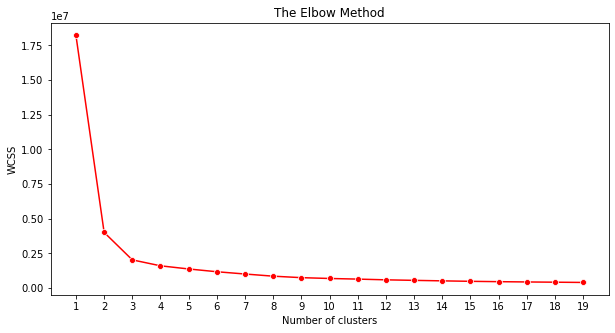

In [13]:
fig = plt.figure(figsize=(10, 5))
fig_1 = sns.lineplot(range(1, 20), wcss, marker='o',color='red')
__ = plt.title('The Elbow Method')
__ = plt.xlabel('Number of clusters')
__ = plt.ylabel('WCSS')
__ = set_x_tick_labels(multiples=1)
__ = plt.show()

In [14]:
kmeans = KMeans(n_clusters=3, init = 'k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(df_cluster_customer[continuous])

In [15]:
df_cluster_customer['Cluster'] = y_kmeans

In [16]:
centroids = {}

for i, feature in enumerate(continuous):
    centroids[feature] = [np.exp(j[i]) for j in kmeans.cluster_centers_]

In [17]:
for feature in continuous:
    df_cluster_customer[feature] = df_cluster_customer[feature].apply(lambda x: np.exp(x))

In [22]:
['Total Revenue',
'Response time in hours', 
'Total Time in hours',
'Service Time in hours', 
'Revenue per hour']

['Total Revenue',
 'Response time in hours',
 'Total Time in hours',
 'Service Time in hours',
 'Revenue per hour']

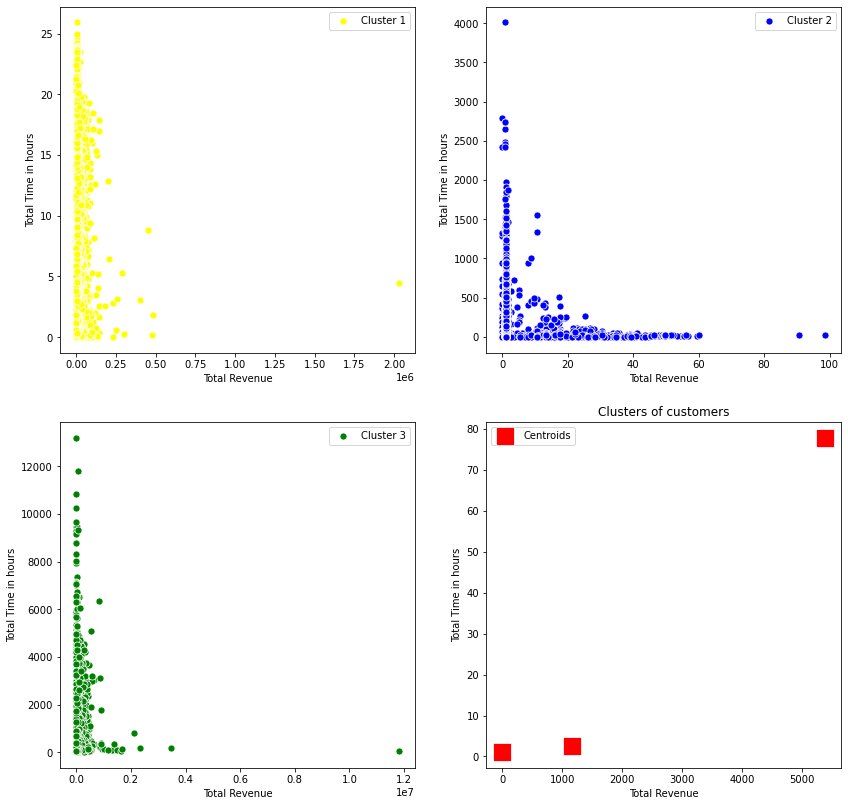

In [29]:
# Visualising the clusters
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

feature_a = 'Total Revenue'
feature_b = 'Total Time in hours'

mask_1 = df_cluster_customer['Cluster'] == 0
fig_1 = sns.scatterplot(df_cluster_customer[mask_1][feature_a], 
                        df_cluster_customer[mask_1][feature_b], 
                        color='yellow', 
                        label='Cluster 1',
                        s=50, 
                        ax=ax[0][0])

mask_2 = df_cluster_customer['Cluster'] == 1
fig_2 = sns.scatterplot(df_cluster_customer[mask_2][feature_a], 
                        df_cluster_customer[mask_2][feature_b], 
                        color='blue', 
                        label='Cluster 2',
                        s=50, 
                        ax=ax[0][1])

mask_3 = df_cluster_customer['Cluster'] == 2
fig_3 = sns.scatterplot(df_cluster_customer[mask_3][feature_a], 
                        df_cluster_customer[mask_3][feature_b], 
                        color='green', 
                        label='Cluster 3',
                        s=50, 
                        ax=ax[1][0])

fig_4 = sns.scatterplot(centroids[feature_a],
                        centroids[feature_b],
                        color='red',
                        label='Centroids',
                        s=300,
                        marker=',', 
                        ax=ax[1][1])

__ = plt.grid(False)
__ = plt.title('Clusters of customers')
__ = plt.xlabel(f'{feature_a}')
__ = plt.ylabel(f'{feature_b}')
__ = plt.legend()

# __ = ax.set_xlim(0, 0.1*1e7)
# __ = ax.set_ylim()

__ = plt.show()

In [49]:
df_cluster_customer['Cars Owned Count'].value_counts().sort_index()

1      549842
2        4781
3         422
4          88
5          40
6          25
7          22
8          13
9           1
10          8
11          5
12          4
13          9
14          5
15          2
16          3
17          3
19          3
20          6
22          1
24          1
25          1
26          1
27          1
29          1
35          1
37          2
39          1
40          1
42          1
43          1
54          1
56          1
57          1
64          1
66          1
76          1
97          1
101         1
102         1
127         1
149         1
212         1
248         1
329         1
359         1
942         1
Name: Cars Owned Count, dtype: int64

In [ ]:
df_cluster_customer['Total Revenue']

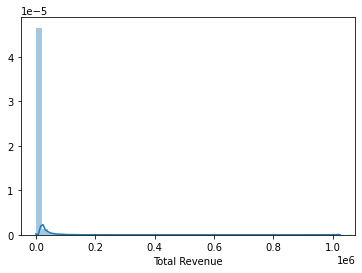

In [51]:
feature = 'Cars Owned Count'
mask = (df_cluster_customer[feature] < 5) 
#         & (df_cluster_customer[feature] < 25000)
sns.distplot(df_cluster_customer[mask]['Total Revenue'])

In [30]:
df_cluster_customer.head()

,CLTV,Cars Owned Count,Plants visited by Customer Count,Customer No._frequency,First_Hand_Owner,Total Revenue,Response time in hours,Total Time in hours,Service Time in hours,Revenue per hour,Cluster
Customer No.,,,,,,,,,,,
1,0,2,1,4,0,1.00,13.042431,1642.632014,1629.589583,1.000000,2
10,0,1,1,5,0,11105.56,12.798444,18.253056,5.454611,608.421969,0
100,0,2,1,2,0,20799.74,10.222083,74.398333,64.176250,279.572661,2
1000,0,1,1,6,0,8813.44,12.434630,4.899167,1.000000,1798.967171,0
10000,0,1,1,7,0,1735.52,11.023532,7.113135,1.000000,243.988061,0


In [344]:
df_cluster_customer['Cluster'].value_counts(normalize=True)

1    0.579439
2    0.224656
0    0.195905
Name: Cluster, dtype: float64

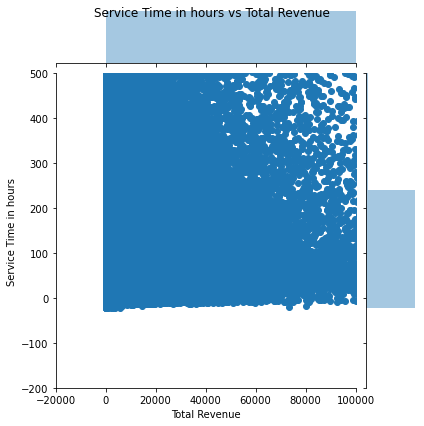

In [281]:
fig, ax = plt.subplots(figsize=(10, 10))

# __ = ax.set_xlim(-3, 50)
# __ = ax.set_ylim(-3, 50)

fig_1 = sns.scatterplot(x='Total Revenue', y='Service Time in hours', 
                        hue='First_Hand_Owner', 
                        data=df_cluster_customer, 
                        ax=ax, 
                       )

fig_2 = sns.lineplot([0, 100], 
                     [0, 100], ax=ax)

__ = plt.xticks(rotation=90)
__ = plt.suptitle('Service Time in hours vs Total Revenue')

__ = plt.show()

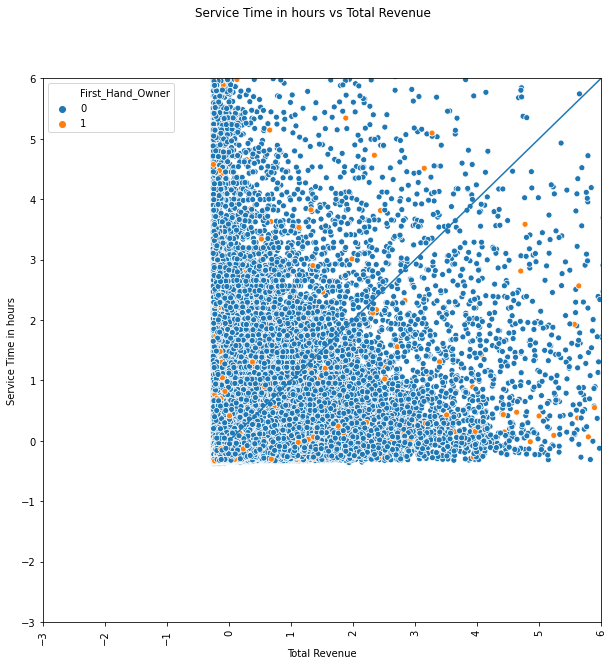

In [254]:
fig, ax = plt.subplots(figsize=(10, 10))

__ = ax.set_xlim(-3, 6)
__ = ax.set_ylim(-3, 6)

fig_1 = sns.scatterplot(x='Total Revenue', y='Service Time in hours', 
                        hue='First_Hand_Owner', 
                        data=df_cluster_std[mask], ax=ax)
fig_2 = sns.lineplot([0, 100], 
                     [0, 100], ax=ax)

__ = plt.xticks(rotation=90)
__ = plt.suptitle('Service Time in hours vs Total Revenue')

__ = plt.show()

In [ ]:
# for customer lifetime value, get the following
#     average order value
#     frequency of visit
#         count invoice
#         measure time between first and last vist
#     customer value = average order value * frequency of visit
#     calculate average customer lifespan
#     cltv = average customer lifespan * customer value

In [ ]:
df_cluster_customer

In [ ]:
# time series analysis